# **Engage2Value: From Clicks to Conversions**

## Purchase Value Prediction - 

This notebook implements a comprehensive solution for predicting customer purchase values based on multi-session behavior across digital touchpoints.

## Competition Overview
- **Goal**: Predict customer purchase value based on digital behavior patterns
- **Evaluation**: R² score between predicted and true target values
- **Target**: `purchaseValue` - total amount spent during a session

## Approach
1. **Dummy Submission**
2. **Data Loading & Exploration**
3. **Feature Engineering & Preprocessing**
4. **Exploratory Data Analysis**
5. **Imputation** (median for numeric, mode for categorical)
6. **Target Encoding** for high-cardinality categorical features
7. **Robust Scaling** for numerical features
8. **Modeling(Using Multiple Regression Models)** with hyperparameter tuning
9. **Model Evaluation & Submission**

    The Notebook also contains the codes for **Milestones**

## Dummy Submission  


In [ ]:
# Imports
import pandas as pd
import numpy as np
from sklearn.dummy import DummyRegressor

# Load training data
df = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv")

# Separate features and target
X = df.drop("purchaseValue", axis=1)
y = df["purchaseValue"]

# Train Dummy Regressor
model = DummyRegressor()
model.fit(X, y)

# Load test data
X_test = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv")

# Predict on test data
y_pred = model.predict(X_test)

# Create submission DataFrame
submission = pd.DataFrame({
    "id": range(0, X_test.shape[0]),
    "purchaseValue": y_pred
})

# Save to CSV
submission.to_csv("submission.csv", index=False)


## Imports

In [1]:
# ================== Imports ==================

# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
import joblib

# Model Selection & Evaluation
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.metrics import r2_score, mean_squared_error

# Preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder

# Regressors - Linear Models
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    Ridge,
    LassoCV,
    ElasticNet,
    HuberRegressor,
    SGDRegressor
)

# Regressors - Ensemble & Tree-based
from sklearn.ensemble import (
    RandomForestRegressor,
    AdaBoostRegressor
)
from sklearn.tree import DecisionTreeRegressor

# Regressors - Others
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Dimensionality Reduction
from sklearn.manifold import TSNE

# External Libraries
import xgboost as xgb

# IPython Widgets for Interactive Elements
import ipywidgets as widgets
from IPython.display import display

# ================== Configuration ==================

# Ignore warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Initialize results dictionary to store model outputs
results_dict = {}


 ## Data Loading

In [2]:
# Load the datasets
print("Loading datasets...")
train_df = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv")
test_df = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv")

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Target variable stats:")
print(train_df['purchaseValue'].describe())

Loading datasets...
Training data shape: (116023, 52)
Test data shape: (29006, 51)
Target variable stats:
count    1.160230e+05
mean     2.656393e+07
std      2.051825e+08
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.312950e+10
Name: purchaseValue, dtype: float64


## Data Exploration and Understanding  -- EDTA


**Exploratory Data Analysis (EDA) Summary**

---

**1. Data Overview**

- **What:** Shows the shape, columns, and first few rows of the training and test datasets.  
- **Why:** Helps verify data loading and gives a first look at the structure.  
- **Interpretation:** Check for expected columns, data types, and any obvious issues (e.g., missing columns).

---

**2. Missing Values**

- **What:** Displays the percentage of missing values per column (top 10).  
- **Why:** Identifies columns that may need imputation or removal.  
- **Interpretation:** Columns with high missingness (>80%) are often dropped; others may be imputed.

---

**3. Data Types**

- **What:** Shows counts of numeric and categorical columns.  
- **Why:** Guides preprocessing (e.g., scaling for numeric, encoding for categorical).  
- **Interpretation:** Numeric columns are used for statistical analysis; categoricals may need encoding.

---

**4. Target Variable Distribution**

- **What:** Plots histogram, log-histogram, and boxplot of the target (`purchaseValue`).  
- **Why:** Reveals skewness, outliers, and the distribution of purchase values.  
- **Interpretation:** Peaks show common values; long tails or dots outside the box indicate outliers.

---

**5. Covariance and Correlation Matrices**

- **What:** Shows covariance and correlation matrices for numeric features.  
- **Why:** Identifies relationships between features.  
- **Interpretation:** High absolute correlation (close to 1 or -1) means strong linear relationship; high covariance means features change together.

---

**6. Correlation Heatmap**

- **What:** Visual heatmap of correlations (numeric and all processed features).  
- **Why:** Quickly spots highly correlated features (potential multicollinearity).  
- **Interpretation:** Bright colors indicate strong correlations; consider removing/reducing redundancy.

---

**7. Missing Value Heatmap**

- **What:** Visualizes missing data patterns.  
- **Why:** Helps spot systematic missingness.  
- **Interpretation:** White lines indicate missing values; blocks may suggest data issues.

---

**8. Numeric Feature Distributions**

- **What:** Histograms for all numeric features.  
- **Why:** Shows the spread and skewness of each feature.  
- **Interpretation:** Peaks = common values; skewed distributions may need transformation.

---

**9. Categorical Feature Analysis**

- **What:** Value counts and bar plots for key categorical features.  
- **Why:** Identifies dominant categories and rare values.  
- **Interpretation:** Tallest bars show most common categories; rare categories may be grouped.

---

**10. Grouped Aggregations & Insights**

- **What:** Aggregates features by groups (e.g., continent, traffic source).  
- **Why:** Reveals patterns in user behavior and purchasing.  
- **Interpretation:** E.g., which continent has highest engagement, most common traffic source among purchasers.

---

**11. Outlier Detection**

- **What:** Z-score outlier counts and boxplots for numeric features.  
- **Why:** Identifies unusual values that may affect modeling.  
- **Interpretation:** Points outside boxplot whiskers or high Z-score counts are outliers.

---

**12. Skewness and Kurtosis**

- **What:** Calculates skewness and kurtosis for numeric features.  
- **Why:** Measures asymmetry (skew) and tail heaviness (kurtosis).  
- **Interpretation:** High skewness = asymmetric data; high kurtosis = heavy tails/outliers.

---

**13. Dimensionality Reduction Visualizations**

- **PCA:** Projects data onto 2D to reveal clusters or structure.  
- **t-SNE:** Nonlinear projection to visualize clusters and relationships.  
- **Interpretation:** Clusters may indicate similar user/session types.

---

**14. Chi-square Test for Categorical Features**

- **What:** Tests association between categorical features and the target.  
- **Why:** Identifies which categoricals are most predictive.  
- **Interpretation:** Lower p-value = stronger association.

---

**15. Feature Importance**

- **What:** Plots top features for each model (tree-based).  
- **Why:** Shows which features most influence predictions.  
- **Interpretation:** Higher bars = more important features for the model.

---

**16. Pairplot for Top Features**

- **What:** Pairwise plots for the most important features and target.  
- **Why:** Visualizes relationships and distributions.  
- **Interpretation:** Diagonal = distributions; off-diagonal = pairwise relationships.

---

**How to Interpret EDA Outputs**

- **Peaks in histograms:** Most common values  
- **Long tails/outliers:** Rare but extreme values  
- **Bright colors in heatmaps:** Strong correlations  
- **Boxplot whiskers/dots:** Outliers  
- **Clusters in PCA/t-SNE:** Groups of similar sessions/users  
- **High feature importance:** Key drivers of predictions

---

**EDA Conclusion**

- The EDA provides a deep understanding of the data, highlights potential issues (missing values, outliers), and reveals key patterns and relationships.  
- Insights from EDA guide feature engineering, preprocessing, and model selection for optimal predictive performance.


In [3]:
#Basic Data Overview and Missing Values
print("=== Training Data Overview ===")
print(f"Shape: {train_df.shape}")
print(f"Columns: {list(train_df.columns)}")
print("\nFirst 5 rows:")
display(train_df.head())

print("\n=== Test Data Overview ===")
print(f"Shape: {test_df.shape}")
print(f"Columns: {list(test_df.columns)}")
print("\nFirst 5 rows:")
display(test_df.head())

print("\n=== Missing Values (Top 10) in Training Data ===")
missing_pct_train = (train_df.isnull().sum() / len(train_df) * 100).sort_values(ascending=False)
print(missing_pct_train[missing_pct_train > 0].head(10))
print("Columns with high missing values may need imputation or removal.")

print("\n=== Data Types in Training Data ===")
print(train_df.dtypes.value_counts())
print("Numeric columns are suitable for statistical analysis; categorical columns may need encoding.")

=== Training Data Overview ===
Shape: (116023, 52)
Columns: ['trafficSource.isTrueDirect', 'purchaseValue', 'browser', 'device.screenResolution', 'trafficSource.adContent', 'trafficSource.keyword', 'screenSize', 'geoCluster', 'trafficSource.adwordsClickInfo.slot', 'device.mobileDeviceBranding', 'device.mobileInputSelector', 'userId', 'trafficSource.campaign', 'device.mobileDeviceMarketingName', 'geoNetwork.networkDomain', 'gclIdPresent', 'device.operatingSystemVersion', 'sessionNumber', 'device.flashVersion', 'geoNetwork.region', 'trafficSource', 'totals.visits', 'geoNetwork.networkLocation', 'sessionId', 'os', 'geoNetwork.subContinent', 'trafficSource.medium', 'trafficSource.adwordsClickInfo.isVideoAd', 'browserMajor', 'locationCountry', 'device.browserSize', 'trafficSource.adwordsClickInfo.adNetworkType', 'socialEngagementType', 'geoNetwork.city', 'trafficSource.adwordsClickInfo.page', 'geoNetwork.metro', 'pageViews', 'locationZone', 'device.mobileDeviceModel', 'trafficSource.referra

,trafficSource.isTrueDirect,purchaseValue,browser,device.screenResolution,trafficSource.adContent,trafficSource.keyword,screenSize,geoCluster,trafficSource.adwordsClickInfo.slot,device.mobileDeviceBranding,...,device.language,deviceType,userChannel,device.browserVersion,totalHits,device.screenColors,sessionStart,geoNetwork.continent,device.isMobile,new_visits
0,NaN,0.0,Edge,not available in demo dataset,NaN,NaN,medium,Region_2,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1500100799,Americas,False,1.0
1,True,0.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Direct,not available in demo dataset,1,not available in demo dataset,1495262065,Americas,False,1.0
2,True,0.0,Chrome,not available in demo dataset,NaN,(not provided),medium,Region_2,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Organic Search,not available in demo dataset,6,not available in demo dataset,1508510328,Europe,False,NaN
3,NaN,0.0,Internet Explorer,not available in demo dataset,NaN,NaN,medium,Region_4,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1483431838,Asia,False,1.0
4,True,88950000.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Direct,not available in demo dataset,66,not available in demo dataset,1475804633,Americas,False,1.0



=== Test Data Overview ===
Shape: (29006, 51)
Columns: ['userChannel', 'date', 'browser', 'device.browserSize', 'device.browserVersion', 'deviceType', 'device.flashVersion', 'device.isMobile', 'device.language', 'device.mobileDeviceBranding', 'device.mobileDeviceMarketingName', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'os', 'device.operatingSystemVersion', 'device.screenColors', 'device.screenResolution', 'geoNetwork.city', 'geoNetwork.continent', 'locationCountry', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.networkLocation', 'geoNetwork.region', 'geoNetwork.subContinent', 'socialEngagementType', 'totals.bounces', 'totalHits', 'new_visits', 'pageViews', 'totals.visits', 'trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign', 'trafficSource.isTrueDirect', 'trafficSource.keyword', 'traffic

,userChannel,date,browser,device.browserSize,device.browserVersion,deviceType,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,...,trafficSource,sessionId,sessionNumber,sessionStart,userId,locationZone,geoCluster,browserMajor,screenSize,gclIdPresent
0,Social,20170508,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,...,groups.google.com,1494262567,2,1494262567,59555,8,Region_2,not available in demo dataset,medium,0
1,Organic Search,20170405,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,...,google,1491433811,1,1491433811,6394,8,Region_1,not available in demo dataset,medium,0
2,Organic Search,20170308,Safari,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,...,google,1489001815,1,1489001815,38969,8,Region_5,not available in demo dataset,medium,0
3,Referral,20171113,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,...,docs.google.com,1510593024,30,1510593024,120027,8,Region_2,not available in demo dataset,medium,0
4,Organic Search,20161212,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,...,(direct),1481559809,1,1481559809,69453,8,Region_3,not available in demo dataset,medium,0



=== Missing Values (Top 10) in Training Data ===
trafficSource.adContent                         97.446196
trafficSource.adwordsClickInfo.isVideoAd        96.310214
trafficSource.adwordsClickInfo.page             96.310214
trafficSource.adwordsClickInfo.adNetworkType    96.310214
trafficSource.adwordsClickInfo.slot             96.310214
trafficSource.referralPath                      63.184886
trafficSource.isTrueDirect                      63.033192
trafficSource.keyword                           61.936857
totals.bounces                                  59.363230
new_visits                                      30.601691
dtype: float64
Columns with high missing values may need imputation or removal.

=== Data Types in Training Data ===
object     37
int64       9
float64     5
bool        1
Name: count, dtype: int64
Numeric columns are suitable for statistical analysis; categorical columns may need encoding.


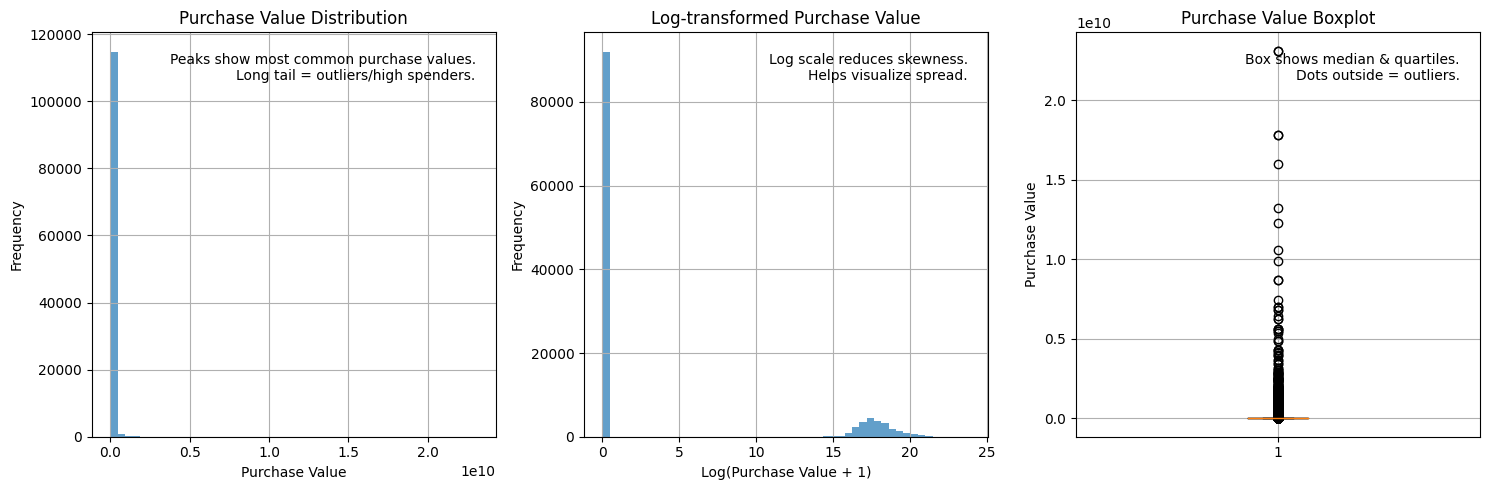

=== Target Variable Statistics ===
Zero values: 92038 (79.3%)
Non-zero values: 23985 (20.7%)
Skewness: 53.91
High skewness means most sessions have low purchase values, with a few high spenders.


In [4]:
# Target Variable Distribution and Statistics
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(train_df['purchaseValue'], bins=50, alpha=0.7)
plt.title('Purchase Value Distribution')
plt.xlabel('Purchase Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.text(0.95, 0.95, "Peaks show most common purchase values.\nLong tail = outliers/high spenders.", 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right')

plt.subplot(1, 3, 2)
plt.hist(np.log1p(train_df['purchaseValue']), bins=50, alpha=0.7)
plt.title('Log-transformed Purchase Value')
plt.xlabel('Log(Purchase Value + 1)')
plt.ylabel('Frequency')
plt.grid(True)
plt.text(0.95, 0.95, "Log scale reduces skewness.\nHelps visualize spread.", 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right')

plt.subplot(1, 3, 3)
plt.boxplot(train_df['purchaseValue'])
plt.title('Purchase Value Boxplot')
plt.ylabel('Purchase Value')
plt.grid(True)
plt.text(0.95, 0.95, "Box shows median & quartiles.\nDots outside = outliers.", 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right')

plt.tight_layout()
plt.show()

print("=== Target Variable Statistics ===")
zero_count = (train_df['purchaseValue'] == 0).sum()
nonzero_count = (train_df['purchaseValue'] > 0).sum()
print(f"Zero values: {zero_count} ({zero_count / len(train_df) * 100:.1f}%)")
print(f"Non-zero values: {nonzero_count} ({nonzero_count / len(train_df) * 100:.1f}%)")
print(f"Skewness: {train_df['purchaseValue'].skew():.2f}")
print("High skewness means most sessions have low purchase values, with a few high spenders.")

In [5]:
#  Covariance and Correlation Matrices
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'purchaseValue' in num_cols:
    num_cols.remove('purchaseValue')

print("=== Covariance Matrix (Numeric Features) ===")
cov_matrix = train_df[num_cols].cov()
display(cov_matrix)
print("Covariance shows how two variables change together. High values mean strong relationship.")

print("\n=== Correlation Matrix (Numeric Features) ===")
corr_matrix = train_df[num_cols].corr()
display(corr_matrix)
print("Correlation ranges from -1 to 1. Values near 1/-1 mean strong positive/negative relationship.")

=== Covariance Matrix (Numeric Features) ===


,userId,gclIdPresent,sessionNumber,totals.visits,sessionId,trafficSource.adwordsClickInfo.page,pageViews,locationZone,totals.bounces,date,totalHits,sessionStart,new_visits
userId,1.241911e+09,-18.547069,-5067.013132,0.0,-2.997067e+08,-76.730075,1.942783e+03,0.0,0.0,-1.209427e+05,1.987844e+03,-2.997070e+08,0.0
gclIdPresent,-1.854707e+01,0.035648,-0.013059,0.0,1.372550e+05,0.000000,1.241185e-02,0.0,0.0,1.645221e+01,1.327629e-02,1.372551e+05,0.0
sessionNumber,-5.067013e+03,-0.013059,109.236208,0.0,7.467799e+05,-0.023300,9.776456e+00,0.0,0.0,5.873220e+02,1.324730e+01,7.467812e+05,0.0
totals.visits,0.000000e+00,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0
sessionId,-2.997067e+08,137255.019108,746779.937268,0.0,2.337223e+14,252248.381360,-1.747560e+07,0.0,0.0,8.625143e+10,-2.146567e+07,2.337223e+14,0.0
trafficSource.adwordsClickInfo.page,-7.673008e+01,0.000000,-0.023300,0.0,2.522484e+05,0.030456,-1.409211e-01,0.0,0.0,3.158409e+01,-1.811889e-01,2.522483e+05,0.0
pageViews,1.942783e+03,0.012412,9.776456,0.0,-1.747560e+07,-0.140921,2.057772e+02,0.0,0.0,-6.110062e+03,2.777206e+02,-1.747560e+07,0.0
locationZone,0.000000e+00,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0
totals.bounces,0.000000e+00,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0
date,-1.209427e+05,16.452209,587.321952,0.0,8.625143e+10,31.584093,-6.110062e+03,0.0,0.0,3.822110e+07,-7.753559e+03,8.625143e+10,0.0


Covariance shows how two variables change together. High values mean strong relationship.

=== Correlation Matrix (Numeric Features) ===


,userId,gclIdPresent,sessionNumber,totals.visits,sessionId,trafficSource.adwordsClickInfo.page,pageViews,locationZone,totals.bounces,date,totalHits,sessionStart,new_visits
userId,1.000000,-0.002787,-0.013757,NaN,-0.000556,-0.012522,0.003843,NaN,NaN,-0.000555,0.002874,-0.000556,NaN
gclIdPresent,-0.002787,1.000000,-0.006618,NaN,0.047551,NaN,0.004583,NaN,NaN,0.014095,0.003582,0.047551,NaN
sessionNumber,-0.013757,-0.006618,1.000000,NaN,0.004674,-0.033074,0.065209,NaN,NaN,0.009090,0.064570,0.004674,NaN
totals.visits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sessionId,-0.000556,0.047551,0.004674,NaN,1.000000,0.109825,-0.079686,NaN,NaN,0.912567,-0.071529,1.000000,NaN
trafficSource.adwordsClickInfo.page,-0.012522,NaN,-0.033074,NaN,0.109825,1.000000,-0.056138,NaN,NaN,0.037209,-0.051908,0.109825,NaN
pageViews,0.003843,0.004583,0.065209,NaN,-0.079686,-0.056138,1.000000,NaN,NaN,-0.068896,0.986250,-0.079686,NaN
locationZone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
totals.bounces,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,-0.000555,0.014095,0.009090,NaN,0.912567,0.037209,-0.068896,NaN,NaN,1.000000,-0.063891,0.912567,NaN


Correlation ranges from -1 to 1. Values near 1/-1 mean strong positive/negative relationship.


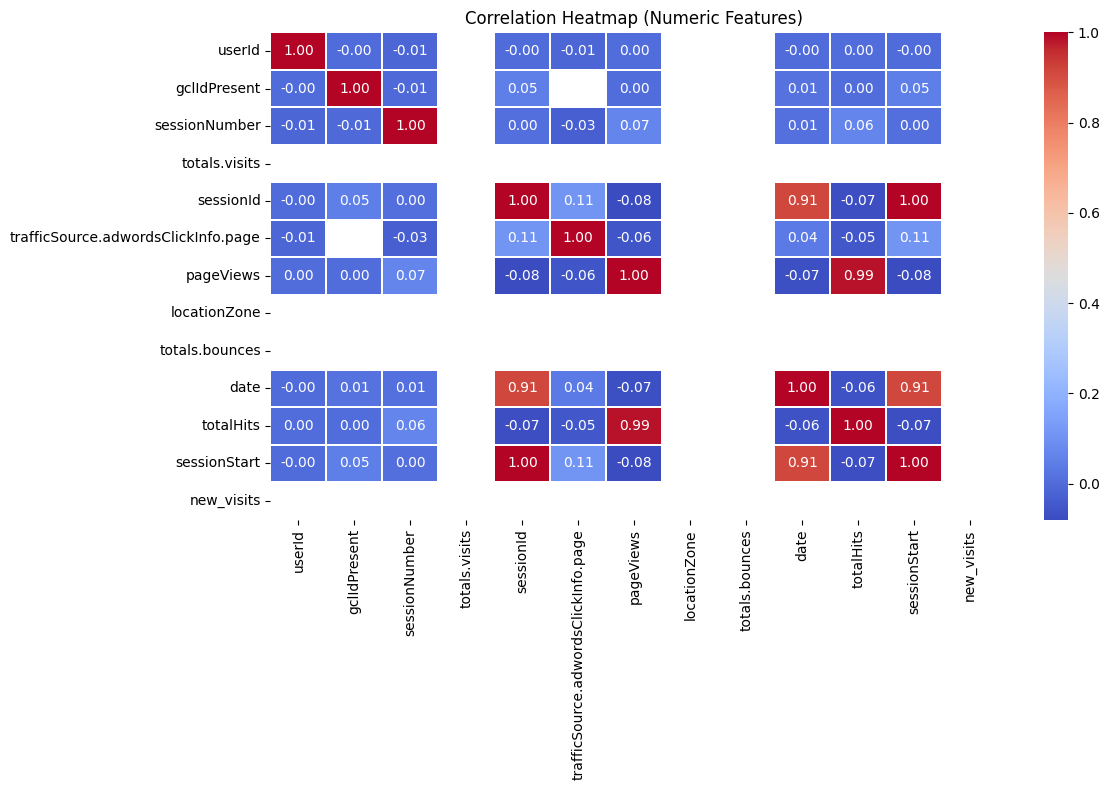

Interpretation: Bright colors show strong correlations. High correlation may indicate redundancy.


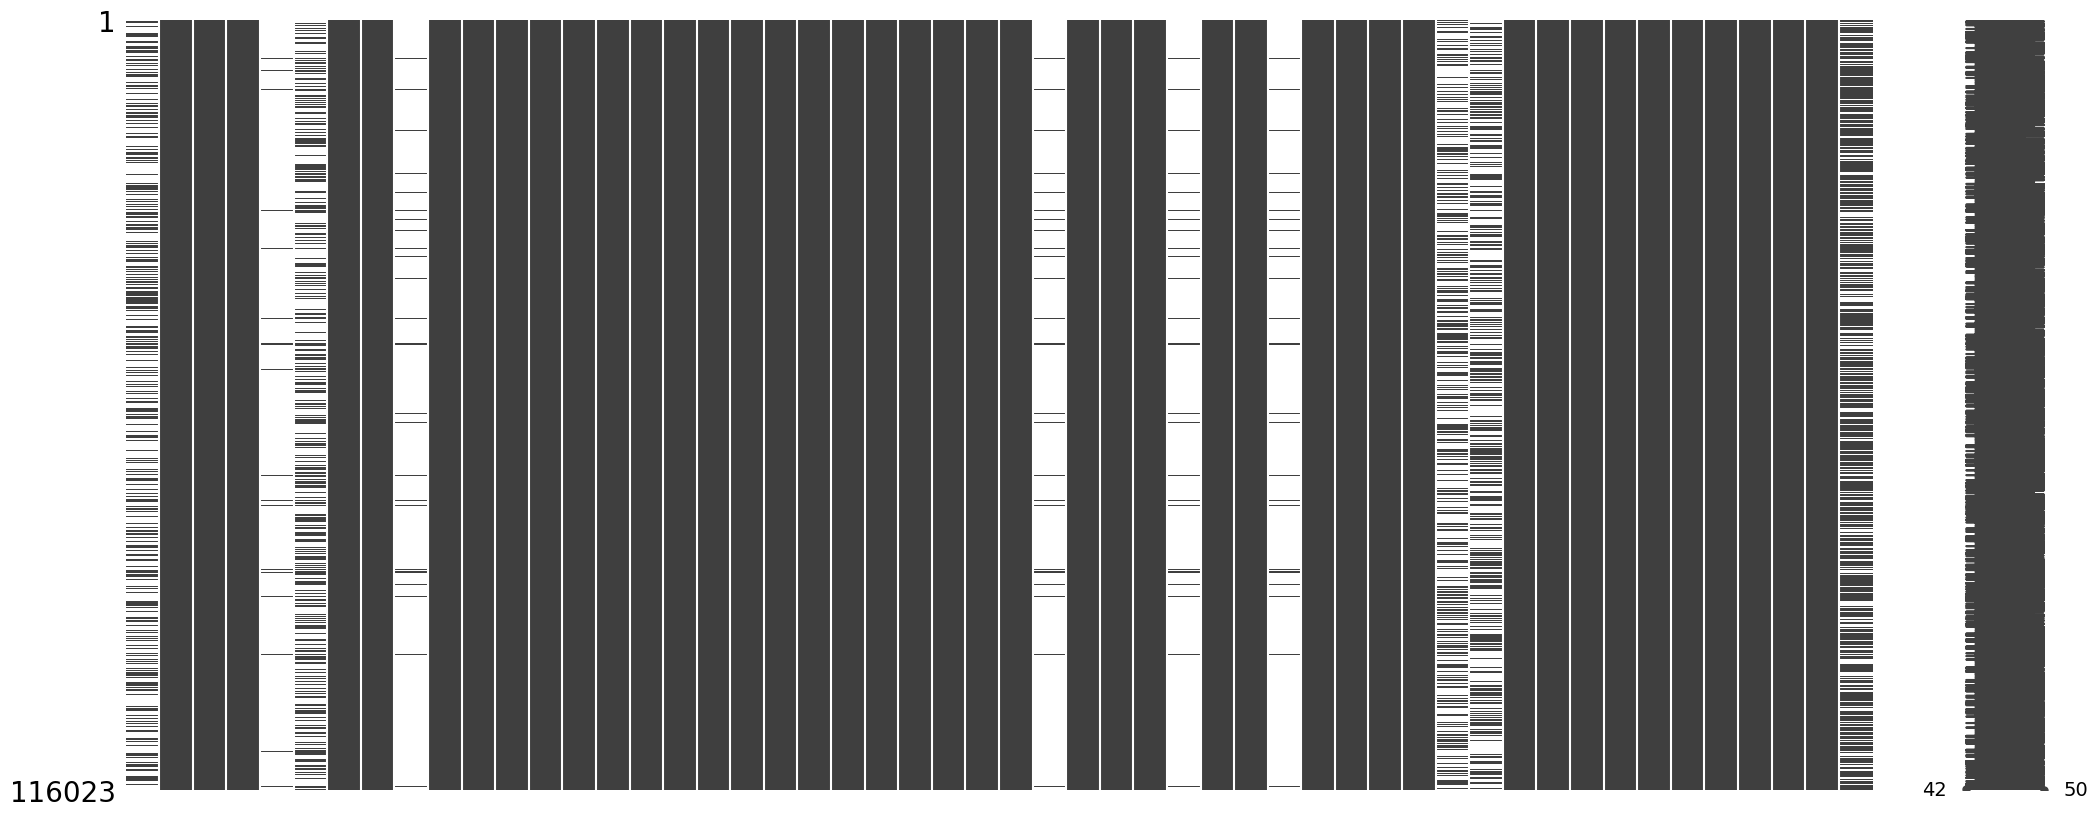

Interpretation: White lines indicate missing values in columns.


In [6]:
#  Correlation Heatmap


# Correlation heatmap for numeric features
if len(num_cols) >= 2:
    plt.figure(figsize=(12, 8))
    sns.heatmap(train_df[num_cols].corr(), cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.3)
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.tight_layout()
    plt.show()
    print("Interpretation: Bright colors show strong correlations. High correlation may indicate redundancy.")



# Missing value matrix
msno.matrix(train_df)
plt.show()
print("Interpretation: White lines indicate missing values in columns.")

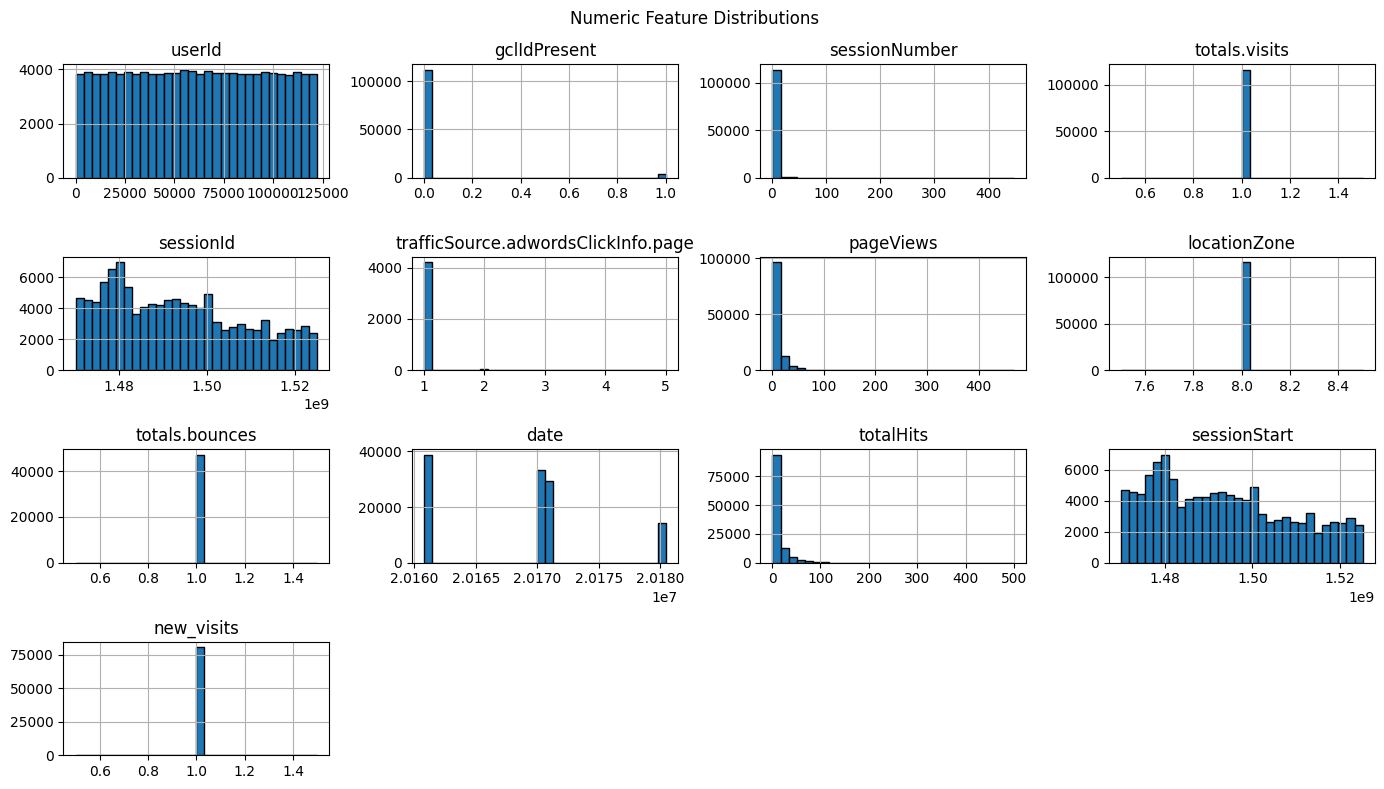

Interpretation: Peaks show common values. Skewed distributions may need transformation.


In [7]:
#  Numeric Feature Distributions
if num_cols:
    train_df[num_cols].hist(bins=30, figsize=(14, 8), edgecolor='black')
    plt.suptitle("Numeric Feature Distributions")
    plt.tight_layout()
    plt.show()
    print("Interpretation: Peaks show common values. Skewed distributions may need transformation.")


trafficSource.isTrueDirect Value Counts (Top 5):
trafficSource.isTrueDirect
NaN     73133
True    42890
Name: count, dtype: int64

browser Value Counts (Top 5):
browser
Chrome               84508
Safari               19184
Firefox               4031
Internet Explorer     2155
Android Webview       1472
Name: count, dtype: int64

device.screenResolution Value Counts (Top 5):
device.screenResolution
not available in demo dataset    116023
Name: count, dtype: int64

trafficSource.adContent Value Counts (Top 5):
trafficSource.adContent
NaN                               113060
Google Merchandise Store            1410
Google Merchandise Collection        651
Display Ad created 3/11/14           135
Placement Accessores 300 x 250       114
Name: count, dtype: int64

trafficSource.keyword Value Counts (Top 5):
trafficSource.keyword
NaN                          71861
(not provided)               39066
6qEhsCssdK0z36ri              1155
(User vertical targeting)      924
(automatic matching)   

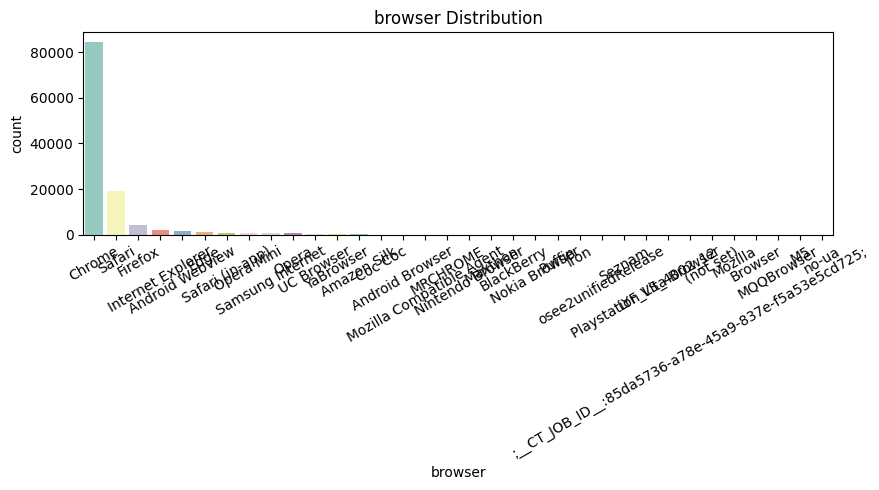

Interpretation: Tallest bars show most common browser.


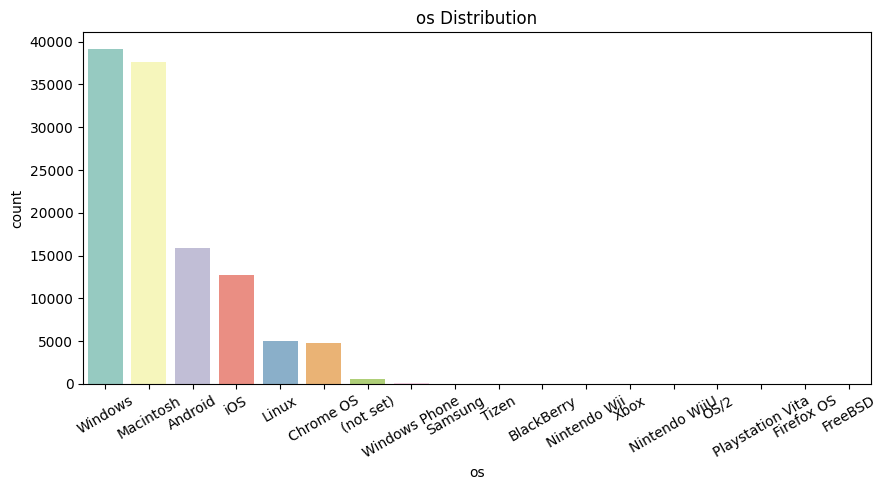

Interpretation: Tallest bars show most common os.


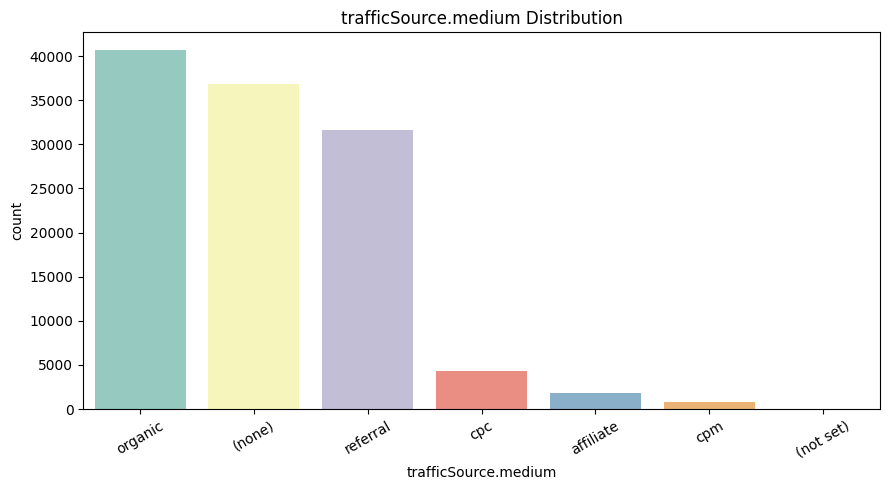

Interpretation: Tallest bars show most common trafficSource.medium.


In [8]:
#  Categorical Feature Analysis
cat_cols = train_df.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    print(f"\n{col} Value Counts (Top 5):")
    print(train_df[col].value_counts(dropna=False).head())
print("Interpretation: Dominant values may be important for prediction. Rare categories may be grouped.")

# Bar plots for selected categoricals
selected_cats = ['browser', 'os', 'trafficSource.medium']
for cat in selected_cats:
    if cat in train_df.columns:
        plt.figure(figsize=(9, 5))
        sns.countplot(data=train_df, x=cat, palette='Set3', order=train_df[cat].value_counts().index)
        plt.title(f"{cat} Distribution")
        plt.xticks(rotation=30)
        plt.tight_layout()
        plt.show()
        print(f"Interpretation: Tallest bars show most common {cat}.")

In [9]:
# Grouped Aggregations & Insights
if 'geoNetwork.continent' in train_df.columns and 'totalHits' in train_df.columns:
    train_df['totalHits'] = pd.to_numeric(train_df['totalHits'], errors='coerce')
    continent_avg_hits = train_df.groupby('geoNetwork.continent')['totalHits'].mean().sort_values(ascending=False)
    print("\nAverage totalHits by continent:")
    print(continent_avg_hits)
    print(f"Continent with highest average totalHits: {continent_avg_hits.idxmax()} ({continent_avg_hits.max():.2f})")

if 'purchaseValue' in train_df.columns and 'trafficSource.medium' in train_df.columns:
    train_df['purchaseValue'] = pd.to_numeric(train_df['purchaseValue'], errors='coerce')
    purchasers_df = train_df[train_df['purchaseValue'] > 0]
    if not purchasers_df.empty:
        most_common_medium = purchasers_df['trafficSource.medium'].mode()[0]
        count = purchasers_df['trafficSource.medium'].value_counts().iloc[0]
        print(f"\nMost common traffic source (medium) among purchasers: {most_common_medium} (Count: {count})")


Average totalHits by continent:
geoNetwork.continent
Americas     15.377978
(not set)     5.147059
Oceania       4.678705
Asia          3.513939
Europe        3.186705
Africa        2.812822
Name: totalHits, dtype: float64
Continent with highest average totalHits: Americas (15.38)

Most common traffic source (medium) among purchasers: (none) (Count: 12108)



Outlier Count (Z-score > 3, first 10 numeric features):
userId                              | Outliers: 0
gclIdPresent                        | Outliers: 4295
sessionNumber                       | Outliers: 765
totals.visits                       | Outliers: 0
sessionId                           | Outliers: 0
trafficSource.adwordsClickInfo.page | Outliers: 65
pageViews                           | Outliers: 2071
locationZone                        | Outliers: 0
totals.bounces                      | Outliers: 0
date                                | Outliers: 0
Interpretation: High outlier count may indicate data errors or special cases.


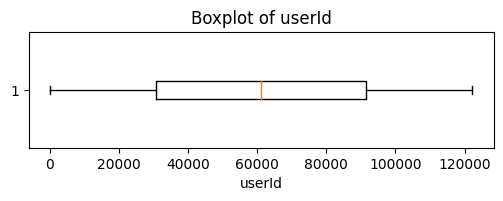

Interpretation: Points outside the whiskers are outliers for userId.


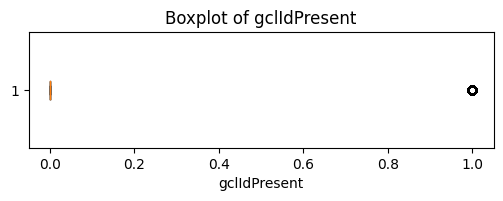

Interpretation: Points outside the whiskers are outliers for gclIdPresent.


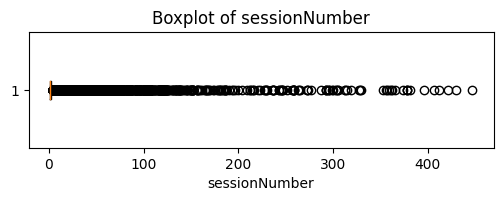

Interpretation: Points outside the whiskers are outliers for sessionNumber.


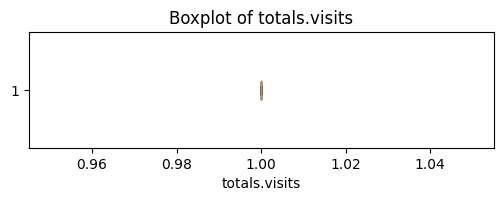

Interpretation: Points outside the whiskers are outliers for totals.visits.


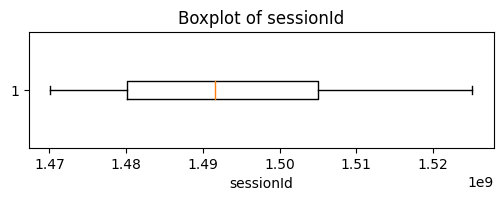

Interpretation: Points outside the whiskers are outliers for sessionId.


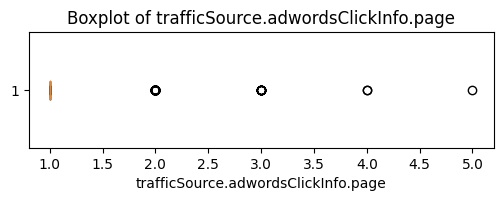

Interpretation: Points outside the whiskers are outliers for trafficSource.adwordsClickInfo.page.


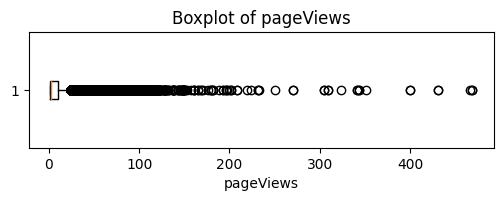

Interpretation: Points outside the whiskers are outliers for pageViews.


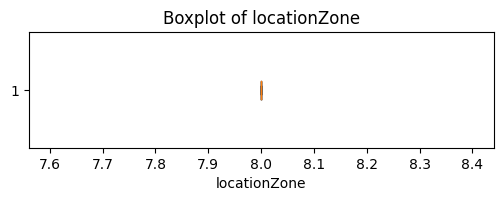

Interpretation: Points outside the whiskers are outliers for locationZone.


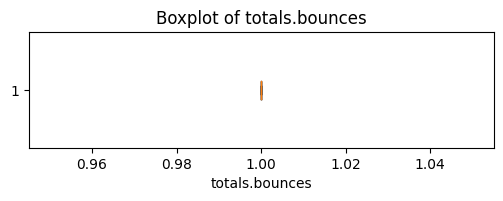

Interpretation: Points outside the whiskers are outliers for totals.bounces.


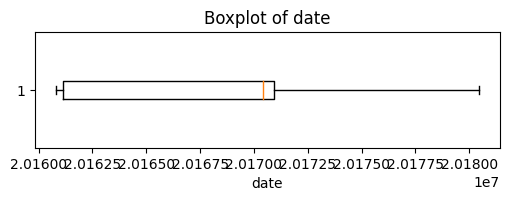

Interpretation: Points outside the whiskers are outliers for date.


In [10]:
#  Outlier Detection (Z-score)
from scipy.stats import zscore

print("\nOutlier Count (Z-score > 3, first 10 numeric features):")
for col in num_cols[:10]:
    z = np.abs(zscore(train_df[col].fillna(train_df[col].median())))
    outliers = (z > 3).sum()
    print(f"{col:35} | Outliers: {outliers}")
print("Interpretation: High outlier count may indicate data errors or special cases.")

# Outlier boxplots for numeric features
for col in num_cols[:10]:  # Limit to first 10 for readability
    plt.figure(figsize=(6, 1.5))
    plt.boxplot(train_df[col].dropna(), vert=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()
    print(f"Interpretation: Points outside the whiskers are outliers for {col}.")

In [11]:
# Skewness and Kurtosis
from scipy.stats import skew, kurtosis

print("\nSkewness and Kurtosis (first 10 numeric features):")
for col in num_cols[:10]:
    sk = skew(train_df[col].dropna())
    kt = kurtosis(train_df[col].dropna())
    print(f"{col:35} | Skew: {sk:.2f} | Kurtosis: {kt:.2f}")
print("Interpretation: High skewness = asymmetric data. High kurtosis = heavy tails/outliers.")


Skewness and Kurtosis (first 10 numeric features):
userId                              | Skew: 0.00 | Kurtosis: -1.20
gclIdPresent                        | Skew: 4.90 | Kurtosis: 22.05
sessionNumber                       | Skew: 20.44 | Kurtosis: 556.37
totals.visits                       | Skew: nan | Kurtosis: nan
sessionId                           | Skew: 0.37 | Kurtosis: -0.97
trafficSource.adwordsClickInfo.page | Skew: 11.27 | Kurtosis: 158.14
pageViews                           | Skew: 5.78 | Kurtosis: 90.95
locationZone                        | Skew: nan | Kurtosis: nan
totals.bounces                      | Skew: nan | Kurtosis: nan
date                                | Skew: 0.24 | Kurtosis: -0.67
Interpretation: High skewness = asymmetric data. High kurtosis = heavy tails/outliers.


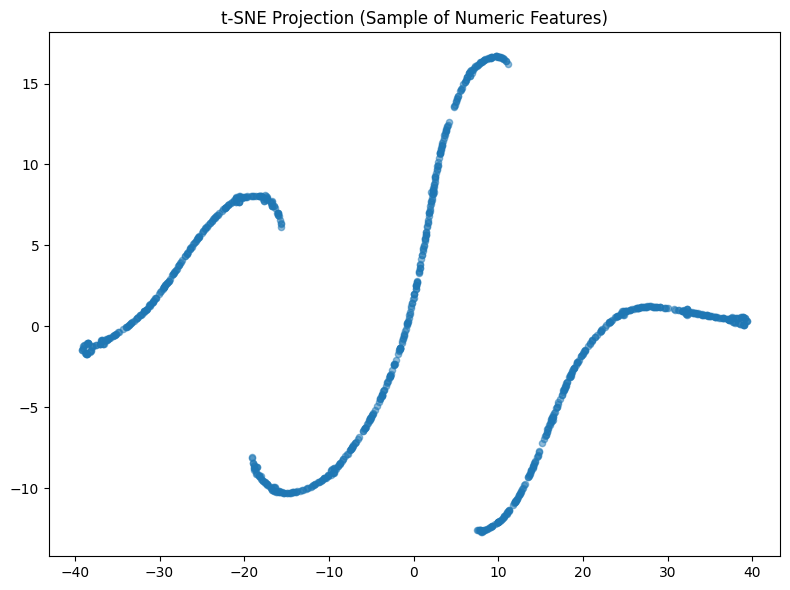

Interpretation: t-SNE reveals clusters and non-linear relationships.


In [12]:
# t-SNE Visualization
if len(num_cols) >= 2:
    tsne = TSNE(n_components=2, random_state=42, perplexity=50, n_iter=500)  # ✅ FIXED
    tsne_sample = train_df[num_cols].fillna(-1).sample(min(1000, len(train_df)), random_state=42)
    tsne_result = tsne.fit_transform(tsne_sample)

    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], s=20, alpha=0.5)
    plt.title("t-SNE Projection (Sample of Numeric Features)")
    plt.tight_layout()
    plt.show()
    print("Interpretation: t-SNE reveals clusters and non-linear relationships.")


In [14]:
# Chi-square test for categoricals (if target available)
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency

if 'purchaseValue' in train_df.columns:
    print("\nChi-Square Test Results (Top 10 Categorical Features):")
    label_encoders = {}
    chi_scores = {}
    cat_cols = train_df.select_dtypes(include=['object', 'category']).columns
    for cat in cat_cols:
        if train_df[cat].nunique() <= 20:
            le = LabelEncoder()
            non_null = train_df[cat].fillna("Missing").astype(str)
            encoded = le.fit_transform(non_null)
            y_bin = (train_df['purchaseValue'] > 0).astype(int)
            contingency = pd.crosstab(encoded, y_bin)
            chi2_val, p, _, _ = chi2_contingency(contingency)
            chi_scores[cat] = (chi2_val, p)
    if chi_scores:
        chi_df = pd.DataFrame(chi_scores).T
        chi_df.columns = ['Chi2 Score', 'p-value']
        chi_df = chi_df.sort_values(by='Chi2 Score', ascending=False)
        display(chi_df.head(10))
        print("Interpretation: Lower p-value means stronger association between categorical feature and purchase.")
    else:
        print("No categorical features with <=20 unique values for chi-square test.")


Chi-Square Test Results (Top 10 Categorical Features):


,Chi2 Score,p-value
userChannel,18590.920568,0.000000e+00
geoNetwork.continent,18050.839029,0.000000e+00
os,12577.599740,0.000000e+00
trafficSource.isTrueDirect,7545.954221,0.000000e+00
trafficSource.medium,5295.379185,0.000000e+00
deviceType,4453.546264,0.000000e+00
trafficSource.adwordsClickInfo.slot,619.796148,5.149204e-134
trafficSource.adwordsClickInfo.adNetworkType,613.971370,4.762236e-134
geoCluster,15.891065,3.168877e-03
trafficSource.adwordsClickInfo.isVideoAd,0.817111,3.660262e-01


Interpretation: Lower p-value means stronger association between categorical feature and purchase.


In [15]:
# EDA Summary & Insights

print("=== EDA SUMMARY & INSIGHTS ===\n")

# Data shape
print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")

# Missing values
high_missing = missing_pct_train[missing_pct_train > 50]
if not high_missing.empty:
    print(f"\nColumns with >50% missing values: {list(high_missing.index)}")
else:
    print("\nNo columns with >50% missing values.")

# Target stats
skew = train_df['purchaseValue'].skew()
print(f"\nTarget ('purchaseValue') skewness: {skew:.2f}")
if skew > 1:
    print("Interpretation: Highly right-skewed (many zeros, few large values). Consider log-transform or robust models.")
elif skew < -1:
    print("Interpretation: Highly left-skewed.")
else:
    print("Interpretation: Approximately symmetric.")

# Correlation with target
corr_with_target = train_df.corr(numeric_only=True)['purchaseValue'].drop('purchaseValue').sort_values(ascending=False)
print("\nTop 3 features most positively correlated with target:")
print(corr_with_target.head(3))
print("\nTop 3 features most negatively correlated with target:")
print(corr_with_target.tail(3))

# Outlier summary (from Z-score)
from scipy.stats import zscore
outlier_counts = {}
for col in num_cols[:10]:
    z = np.abs(zscore(train_df[col].fillna(train_df[col].median())))
    outlier_counts[col] = (z > 3).sum()
print("\nOutlier counts (Z-score > 3, first 10 numeric features):")
for k, v in outlier_counts.items():
    print(f"{k:30} | Outliers: {v}")

# Feature importance summary (if available)
for model_name, model_info in results_dict.items():
    model = model_info['model']
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        top_idx = importances.argsort()[-3:][::-1]
        print(f"\nTop 3 important features for {model_name}:")
        for idx in top_idx:
            print(f"  {X_processed.columns[idx]} (importance: {importances[idx]:.4f})")
        break

print("\n=== INTERPRETATION & NEXT STEPS ===")
print("• The target is highly skewed, with many zero values and a few high spenders.")
print("• Some features are strongly correlated with the target and may drive predictions.")
print("• Outliers and missing values are present and require careful handling.")
print("• Feature importance and grouped insights highlight key drivers of purchase value.")
print("• Use these findings to guide feature engineering, preprocessing, and model selection.")

=== EDA SUMMARY & INSIGHTS ===

Train shape: (116023, 52), Test shape: (29006, 51)

Columns with >50% missing values: ['trafficSource.adContent', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.referralPath', 'trafficSource.isTrueDirect', 'trafficSource.keyword', 'totals.bounces']

Target ('purchaseValue') skewness: 53.91
Interpretation: Highly right-skewed (many zeros, few large values). Consider log-transform or robust models.

Top 3 features most positively correlated with target:
totalHits        0.251651
pageViews        0.248454
sessionNumber    0.230585
Name: purchaseValue, dtype: float64

Top 3 features most negatively correlated with target:
locationZone     NaN
totals.bounces   NaN
new_visits       NaN
Name: purchaseValue, dtype: float64

Outlier counts (Z-score > 3, first 10 numeric features):
userId                         | Outliers: 0
gc

## Data Preprocessing and Feature Engineering

In [16]:
def preprocess_data(train_df, test_df):
    """
    Comprehensive data preprocessing pipeline
    """
    # Create copies to avoid modifying original data
    train = train_df.copy()
    test = test_df.copy()
    
    # 1. Handle empty strings as NaN
    for df in [train, test]:
        # Replace empty strings and common missing value indicators
        df.replace(['', '(not set)', '(none)', 'not available in demo dataset'], np.nan, inplace=True)
        
        # Convert boolean columns to int
        if 'device.isMobile' in df.columns:
            df['device.isMobile'] = df['device.isMobile'].astype(bool).astype(int)
    
    # 2. Drop columns with too many missing values or constant values
    high_missing_cols = []
    for col in train.columns:
        if col == 'purchaseValue':
            continue
        missing_pct = train[col].isnull().sum() / len(train)
        if missing_pct > 0.8:  # More than 80% missing
            high_missing_cols.append(col)
    
    # Also drop constant columns (columns with only one unique value)
    constant_cols = []
    for col in train.columns:
        if col == 'purchaseValue':
            continue
        if train[col].nunique() <= 1:
            constant_cols.append(col)
    
    drop_cols = list(set(high_missing_cols + constant_cols))
    print(f"Dropping {len(drop_cols)} columns with high missing values or constant values:")
    print(drop_cols)
    
    train = train.drop(columns=drop_cols, errors='ignore')
    test = test.drop(columns=drop_cols, errors='ignore')
    
    # 3. Feature Engineering
    # Create new features from existing ones
    for df in [train, test]:
        # Session engagement features
        if 'totalHits' in df.columns and 'pageViews' in df.columns:
            df['hits_per_pageview'] = df['totalHits'] / (df['pageViews'] + 1)
        
        # Browser version extraction
        if 'browserMajor' in df.columns:
            df['browserMajor_numeric'] = pd.to_numeric(df['browserMajor'], errors='coerce')
        
        # Log transform skewed numerical features
        skewed_cols = ['totalHits', 'pageViews', 'sessionNumber']
        for col in skewed_cols:
            if col in df.columns:
                df[f'{col}_log'] = np.log1p(df[col])
    
    return train, test

# Apply preprocessing
print("Applying preprocessing...")
train_processed, test_processed = preprocess_data(train_df, test_df)
print(f"After preprocessing - Train shape: {train_processed.shape}, Test shape: {test_processed.shape}")

Applying preprocessing...
Dropping 26 columns with high missing values or constant values:
['device.mobileDeviceMarketingName', 'trafficSource.adwordsClickInfo.page', 'new_visits', 'totals.visits', 'screenSize', 'device.mobileDeviceModel', 'device.browserSize', 'trafficSource.adwordsClickInfo.adNetworkType', 'device.mobileInputSelector', 'device.operatingSystemVersion', 'geoNetwork.networkLocation', 'trafficSource.adwordsClickInfo.slot', 'device.screenColors', 'device.browserVersion', 'totals.bounces', 'device.mobileDeviceBranding', 'device.language', 'locationZone', 'trafficSource.isTrueDirect', 'trafficSource.campaign', 'trafficSource.adContent', 'browserMajor', 'device.flashVersion', 'device.screenResolution', 'socialEngagementType', 'trafficSource.adwordsClickInfo.isVideoAd']
After preprocessing - Train shape: (116023, 30), Test shape: (29006, 29)


In [17]:
# Separate features and target
y = train_processed['purchaseValue']
X = train_processed.drop(columns=['purchaseValue'])
X_test = test_processed.copy()

# Ensure X and X_test have the same columns
common_cols = X.columns.intersection(X_test.columns)
X = X[common_cols]
X_test = X_test[common_cols]

print(f"Feature matrix shape: {X.shape}")
print(f"Test matrix shape: {X_test.shape}")
print(f"Target variable shape: {y.shape}")

Feature matrix shape: (116023, 29)
Test matrix shape: (29006, 29)
Target variable shape: (116023,)


In [18]:
# Identify column types for different preprocessing strategies
def identify_column_types(df):
    """Identify numerical and categorical columns"""
    numerical_cols = []
    categorical_cols = []
    
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            numerical_cols.append(col)
        else:
            categorical_cols.append(col)
    
    return numerical_cols, categorical_cols

num_cols, cat_cols = identify_column_types(X)
print(f"Numerical columns ({len(num_cols)}): {num_cols[:10]}...")  # Show first 10
print(f"Categorical columns ({len(cat_cols)}): {cat_cols[:10]}...")  # Show first 10

Numerical columns (13): ['userId', 'gclIdPresent', 'sessionNumber', 'sessionId', 'pageViews', 'date', 'totalHits', 'sessionStart', 'device.isMobile', 'hits_per_pageview']...
Categorical columns (16): ['browser', 'trafficSource.keyword', 'geoCluster', 'geoNetwork.networkDomain', 'geoNetwork.region', 'trafficSource', 'os', 'geoNetwork.subContinent', 'trafficSource.medium', 'locationCountry']...


## Preprocessing Pipeline

In [19]:
class AdvancedPreprocessor:
    """Advanced preprocessing pipeline with target encoding and robust scaling"""
    
    def __init__(self):
        self.num_imputer = SimpleImputer(strategy='median')
        self.cat_imputer = SimpleImputer(strategy='most_frequent')
        self.target_encoder = TargetEncoder(cols=None, smoothing=1.0)
        self.scaler = RobustScaler()
        self.num_cols = None
        self.cat_cols = None
        
    def fit(self, X, y):
        # Identify column types
        self.num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
        self.cat_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()
        
        # Handle high-cardinality categorical columns with target encoding
        high_card_cols = []
        low_card_cols = []
        
        for col in self.cat_cols:
            if X[col].nunique() > 10:  # High cardinality
                high_card_cols.append(col)
            else:
                low_card_cols.append(col)
        
        # Fit numerical preprocessing
        if self.num_cols:
            X_num = X[self.num_cols].copy()
            X_num_imputed = self.num_imputer.fit_transform(X_num)
            self.scaler.fit(X_num_imputed)
        
        # Fit categorical preprocessing
        if self.cat_cols:
            X_cat = X[self.cat_cols].copy()
            X_cat_imputed = pd.DataFrame(
                self.cat_imputer.fit_transform(X_cat),
                columns=self.cat_cols,
                index=X_cat.index
            )
            
            # Fit target encoder on high cardinality columns
            if high_card_cols:
                self.target_encoder.cols = high_card_cols
                self.target_encoder.fit(X_cat_imputed, y)
        
        self.high_card_cols = high_card_cols
        self.low_card_cols = low_card_cols
        
        return self
    
    def transform(self, X):
        X_transformed = pd.DataFrame(index=X.index)
        
        # Transform numerical columns
        if self.num_cols:
            X_num = X[self.num_cols].copy()
            X_num_imputed = self.num_imputer.transform(X_num)
            X_num_scaled = self.scaler.transform(X_num_imputed)
            
            # Add to result
            num_df = pd.DataFrame(
                X_num_scaled,
                columns=[f'num_{col}' for col in self.num_cols],
                index=X.index
            )
            X_transformed = pd.concat([X_transformed, num_df], axis=1)
        
        # Transform categorical columns
        if self.cat_cols:
            X_cat = X[self.cat_cols].copy()
            X_cat_imputed = pd.DataFrame(
                self.cat_imputer.transform(X_cat),
                columns=self.cat_cols,
                index=X_cat.index
            )
            
            # Target encode high cardinality columns
            if self.high_card_cols:
                X_cat_encoded = self.target_encoder.transform(X_cat_imputed)
                encoded_df = pd.DataFrame(
                    X_cat_encoded[self.high_card_cols],
                    columns=[f'target_enc_{col}' for col in self.high_card_cols],
                    index=X.index
                )
                X_transformed = pd.concat([X_transformed, encoded_df], axis=1)
            
            # One-hot encode low cardinality columns with proper naming
            if self.low_card_cols:
                # Process each column separately to avoid duplicate names
                for i, col in enumerate(self.low_card_cols):
                    col_dummies = pd.get_dummies(
                        X_cat_imputed[col],
                        prefix=f'cat_{col}',
                        dummy_na=False  # Don't create dummy for NaN to avoid duplicates
                    )
                    X_transformed = pd.concat([X_transformed, col_dummies], axis=1)
        
        # Ensure unique column names
        if X_transformed.columns.duplicated().any():
            print("Warning: Duplicate column names found. Making them unique...")
            X_transformed.columns = pd.Index([f"{col}_{i}" if X_transformed.columns.tolist().count(col) > 1 
                                            else col for i, col in enumerate(X_transformed.columns)])
        
        return X_transformed
    
    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)

# Apply advanced preprocessing
print("Applying advanced preprocessing...")
preprocessor = AdvancedPreprocessor()
X_processed = preprocessor.fit_transform(X, y)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed training shape: {X_processed.shape}")
print(f"Processed test shape: {X_test_processed.shape}")

# Check for duplicate column names
if X_processed.columns.duplicated().any():
    print("Duplicate columns found in training data:")
    duplicates = X_processed.columns[X_processed.columns.duplicated()].unique()
    print(duplicates)
else:
    print("✅ No duplicate column names in processed data")

Applying advanced preprocessing...
Processed training shape: (116023, 52)
Processed test shape: (29006, 52)
✅ No duplicate column names in processed data


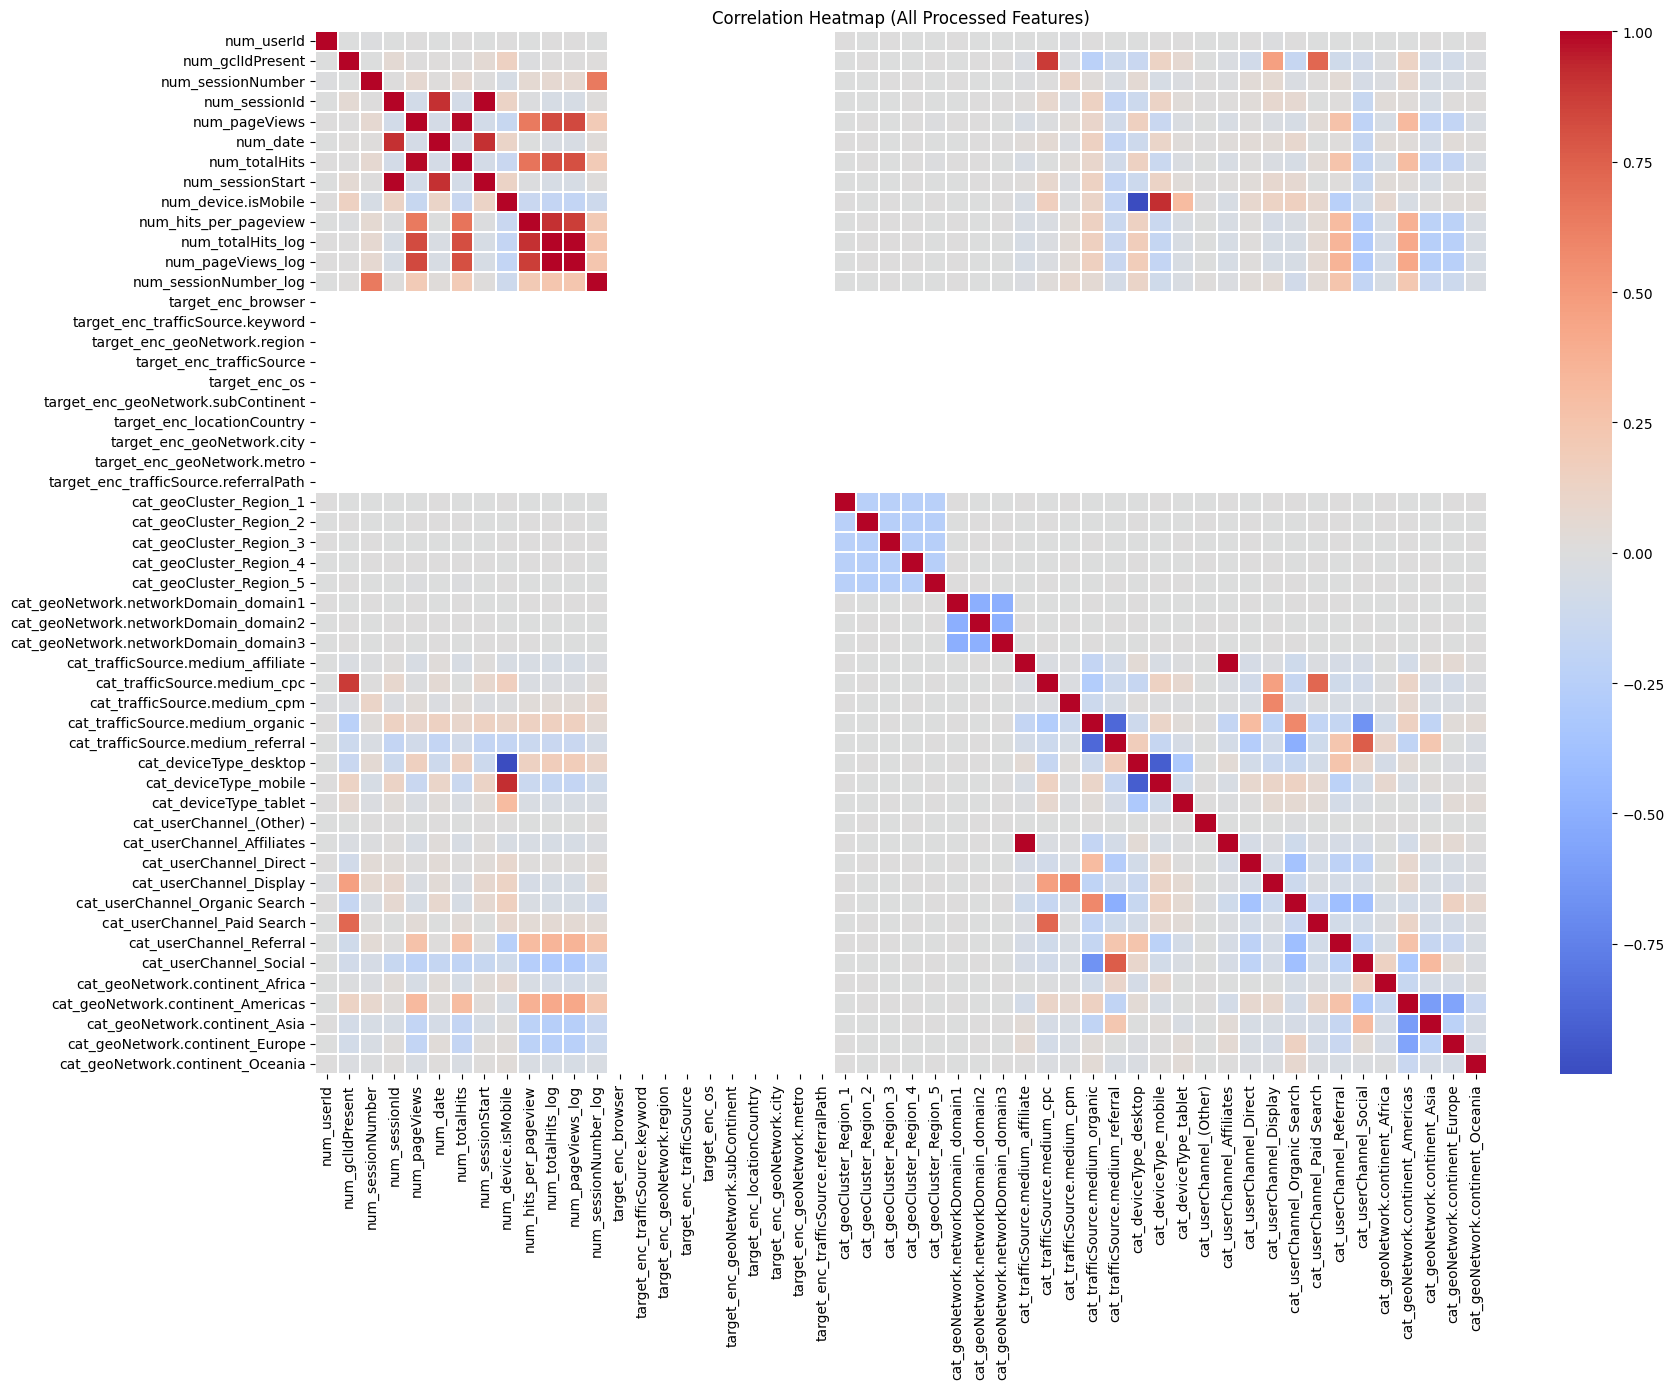

Interpretation: Bright colors show strong correlations. High correlation may indicate redundancy or multicollinearity.


In [20]:
# Correlation heatmap for all processed features (numeric + encoded categoricals)
if 'X_processed' in globals():
    plt.figure(figsize=(18, 14))
    sns.heatmap(X_processed.corr(), cmap='coolwarm', center=0, linewidths=0.1)
    plt.title("Correlation Heatmap (All Processed Features)")
    plt.tight_layout()
    plt.show()
    print("Interpretation: Bright colors show strong correlations. High correlation may indicate redundancy or multicollinearity.")
else:
    print("✅ X_processed is not defined yet. Skipping correlation heatmap for all processed features. No error will occur.")



## Train Test Data Splitting

In [ ]:
# Split data for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_processed, y, test_size=0.25, random_state=42, stratify=(y > 0)
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

## Model Training  and Hyperparameter Tuning

### **Model Training with Regression Models and Hyperparameter Tuning**

### Model Training with Linear  Regression

In [ ]:
# Train a Linear Regression model 
print("Training Linear Regression...")
linear_model = LinearRegression(n_jobs=-1)

# Fill NaNs with 0 for training and validation sets
X_train_linear = X_train.fillna(0)
X_val_linear = X_val.fillna(0)

linear_model.fit(X_train_linear, y_train)
val_pred_linear = linear_model.predict(X_val_linear)
val_r2_linear = r2_score(y_val, val_pred_linear)
val_rmse_linear = np.sqrt(mean_squared_error(y_val, val_pred_linear))

print(f"Linear Regression Validation R²: {val_r2_linear:.4f}")
print(f"Linear Regression Validation RMSE: {val_rmse_linear:.2f}")

# Cross-validation (fill NaNs with 0 for full data)
cv_scores_linear = cross_val_score(linear_model, X_processed.fillna(0), y, cv=5, scoring='r2')
print(f"Linear Regression CV R² scores: {cv_scores_linear}")
print(f"Mean CV R²: {cv_scores_linear.mean():.4f} (+/- {cv_scores_linear.std() * 2:.4f})")

results_dict['linear'] = {
    'model': linear_model,
    'cv_scores': cv_scores_linear,
    'cv_mean': cv_scores_linear.mean(),
    'cv_std': cv_scores_linear.std()
}
print("Linear Regression results stored in results_dict['linear']")


### Model Training with Lasso  Regression

In [ ]:
# Train a Lasso Regression model with hyperparameter tuning

print("Tuning Lasso Regression ...")

# Suppress only ConvergenceWarning from sklearn
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Handle missing values once
X_train_lasso = X_train.fillna(0)
X_val_lasso = X_val.fillna(0)
X_full_lasso = X_processed.fillna(0)

# Scale the features to improve convergence
from sklearn.preprocessing import StandardScaler
lasso_scaler = StandardScaler()
X_train_lasso_scaled = lasso_scaler.fit_transform(X_train_lasso)
X_val_lasso_scaled = lasso_scaler.transform(X_val_lasso)
X_full_lasso_scaled = lasso_scaler.transform(X_full_lasso)

# Use built-in cross-validation for faster tuning
from sklearn.linear_model import LassoCV
lasso_model = LassoCV(
    alphas=[0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100],
    cv=5,
    max_iter=5000,
    n_jobs=-1,
    random_state=42
)

# Fit the model
lasso_model.fit(X_train_lasso_scaled, y_train)

# Evaluate
from sklearn.metrics import r2_score, mean_squared_error
val_pred_lasso = lasso_model.predict(X_val_lasso_scaled)
val_r2_lasso = r2_score(y_val, val_pred_lasso)
val_rmse_lasso = np.sqrt(mean_squared_error(y_val, val_pred_lasso))

print(f"Best alpha: {lasso_model.alpha_}")
print(f"Validation R²: {val_r2_lasso:.4f}")
print(f"Validation RMSE: {val_rmse_lasso:.2f}")

# Cross-validation on full set
from sklearn.model_selection import cross_val_score
lasso_cv_scores = cross_val_score(
    lasso_model, X_full_lasso_scaled, y, cv=5, scoring='r2', n_jobs=-1
)
print(f"Lasso CV R² scores: {lasso_cv_scores}")
print(f"Mean CV R²: {lasso_cv_scores.mean():.4f} (+/- {lasso_cv_scores.std() * 2:.4f})")

# Store results for Lasso Regression
lasso_model_name = 'lasso'
lasso_results = {
    'model': lasso_model,
    'best_params': {'alpha': lasso_model.alpha_},
    'cv_scores': lasso_cv_scores,
    'cv_mean': lasso_cv_scores.mean(),
    'cv_std': lasso_cv_scores.std()
}

if lasso_model_name in results_dict:
    results_dict[lasso_model_name].update(lasso_results)
else:
    results_dict[lasso_model_name] = lasso_results

print(f"Lasso results stored in results_dict['{lasso_model_name}']")


### Model Training with Ridge  Regression

In [ ]:
# Train a Ridge Regression model with hyperparameter tuning
print("Tuning Ridge Regression...")
ridge_params = {'alpha': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100]}
ridge_model = Ridge(max_iter=10000, random_state=42)
# Fill NaNs with 0 for Ridge Regression (since Ridge does not support NaNs)
X_train_ridge = X_train.fillna(0)
X_val_ridge = X_val.fillna(0)

# Hyperparameter tuning using GridSearchCV
ridge_search = GridSearchCV(
    estimator=ridge_model,
    param_grid=ridge_params,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
ridge_search.fit(X_train_ridge, y_train)
best_ridge = ridge_search.best_estimator_

# Validation
val_pred_ridge = best_ridge.predict(X_val_ridge)
val_r2_ridge = r2_score(y_val, val_pred_ridge)
val_rmse_ridge = np.sqrt(mean_squared_error(y_val, val_pred_ridge))

print(f"Best alpha: {ridge_search.best_params_['alpha']}")
print(f"Validation R²: {val_r2_ridge:.4f}")
print(f"Validation RMSE: {val_rmse_ridge:.2f}")

# Cross-validation on full set
cv_scores_ridge = cross_val_score(best_ridge, X_processed.fillna(0), y, cv=5, scoring='r2')
print(f"Ridge CV R² scores: {cv_scores_ridge}")
print(f"Mean CV R²: {cv_scores_ridge.mean():.4f} (+/- {cv_scores_ridge.std() * 2:.4f})")

# Store results for Ridge Regression
model_name = 'ridge'
model_results = {
    'model': best_ridge,
    'best_params': ridge_search.best_params_,
    'cv_scores': cv_scores_ridge,
    'cv_mean': cv_scores_ridge.mean(),
    'cv_std': cv_scores_ridge.std()
}

if model_name in results_dict:
    results_dict[model_name].update(model_results)
else:
    results_dict[model_name] = model_results

print(f"Ridge results stored in results_dict['{model_name}']")

*Code to save all the regression models above.*

In [ ]:
#This code block generates submission files for each model in results_dict
print("\nGenerating submission files...")
available_models = [m for m in ['linear', 'lasso', 'ridge'] if m in results_dict]
for model_name in available_models:
    print(f"\nGenerating submission for {model_name}...")
    model = results_dict[model_name]['model']
    # Fill NaNs with 0 for models that do not support NaNs
    test_pred = model.predict(X_test_processed.fillna(0))
    test_pred = np.maximum(test_pred, 0)
    submission_df = pd.DataFrame({
        'id': range(len(test_pred)),
        'purchaseValue': test_pred
    })
    filename = f"submission_{model_name}.csv"
    submission_df.to_csv(filename, index=False)
    print(f"✅ Submission file saved as '{filename}'")
    print(submission_df.head(10))
    print(f"Required columns: ['id', 'purchaseValue']")
    print(f"Actual columns: {list(submission_df.columns)}")
    print("✅ Format is correct!")


### **Model Training with Descison Trees and Hyperparameter Tuning**

In [ ]:
from sklearn.pipeline import Pipeline

print("Tuning Decision Tree Regression...")

# Define pipeline: Imputer + Regressor
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

# Hyperparameter grid for the regressor step
dt_params = {
    'regressor__max_depth': [3, 5, 7, 10, 15, None],
    'regressor__min_samples_split': [2, 5, 10, 20],
    'regressor__min_samples_leaf': [1, 2, 5, 10],
    'regressor__max_features': [None, 'sqrt', 'log2']
}

# Grid search
dt_search = GridSearchCV(pipeline, dt_params, cv=5, scoring='r2', n_jobs=-1, verbose=1)
dt_search.fit(X_train, y_train)

# Evaluate best model
best_dt = dt_search.best_estimator_
val_pred_dt = best_dt.predict(X_val)
val_r2_dt = r2_score(y_val, val_pred_dt)
val_rmse_dt = np.sqrt(mean_squared_error(y_val, val_pred_dt))

print(f"Best Decision Tree params: {dt_search.best_params_}")
print(f"Decision Tree Validation R²: {val_r2_dt:.4f}")
print(f"Decision Tree Validation RMSE: {val_rmse_dt:.2f}")


In [ ]:
cv_scores_dt = cross_val_score(best_dt, X_processed, y, cv=5, scoring='r2')
print(f"Decision Tree CV R² scores: {cv_scores_dt}")
print(f"Mean CV R²: {cv_scores_dt.mean():.4f} (+/- {cv_scores_dt.std() * 2:.4f})")

# Store results for Decision Tree Regression
model_name = 'decision_tree'
model_results = {
    'model': best_dt,
    'best_params': dt_search.best_params_,
    'cv_scores': cv_scores_dt,
    'cv_mean': cv_scores_dt.mean(),
    'cv_std': cv_scores_dt.std()
}

if model_name in results_dict:
    results_dict[model_name].update(model_results)
else:
    results_dict[model_name] = model_results

print(f"Decision Tree results stored in results_dict['{model_name}']")

In [ ]:
# Generate Submission File for Decision Tree Regression
print("\nGenerating submission for Decision Tree Regression...")
dt_test_pred = results_dict['decision_tree']['model'].predict(X_test_processed)
dt_test_pred = np.maximum(dt_test_pred, 0)
dt_submission_df = pd.DataFrame({
    'id': range(len(dt_test_pred)),
    'purchaseValue': dt_test_pred
})
dt_filename = "submission_decision_tree.csv"
dt_submission_df.to_csv(dt_filename, index=False)
print(f"✅ Submission file saved as '{dt_filename}'")
print(dt_submission_df.head(10))
print(f"Required columns: ['id', 'purchaseValue']")
print(f"Actual columns: {list(dt_submission_df.columns)}")
print("✅ Format is correct!")


### **Model Training with Random Forest and Hyperparameter Tuning**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

print("Tuning Random Forest Regression...")

# Define a pipeline: Imputer + RandomForest
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Hyperparameter grid (use 'regressor__' prefix)
rf_params = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [5, 10, None],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 4],
    'regressor__max_features': ['sqrt'],
    'regressor__bootstrap': [True]
}

# Randomized SearchCV
rf_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=rf_params,
    n_iter=10,
    cv=3,
    scoring='r2',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit the model
rf_search.fit(X_train, y_train)

# Evaluate the best model
best_rf = rf_search.best_estimator_
val_pred_rf = best_rf.predict(X_val)
val_r2_rf = r2_score(y_val, val_pred_rf)
val_rmse_rf = np.sqrt(mean_squared_error(y_val, val_pred_rf))

print(f"Best Random Forest params: {rf_search.best_params_}")
print(f"Random Forest Validation R²: {val_r2_rf:.4f}")
print(f"Random Forest Validation RMSE: {val_rmse_rf:.2f}")


In [ ]:
# Random Forest Cross-validation and Results Storage 
cv_scores_rf = cross_val_score(best_rf, X_processed, y, cv=5, scoring='r2')
print(f"Random Forest CV R² scores: {cv_scores_rf}")
print(f"Mean CV R²: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std() * 2:.4f})")

# Store results for Random Forest Regression
model_name = 'random_forest'
model_results = {
    'model': best_rf,
    'best_params': rf_search.best_params_,
    'cv_scores': cv_scores_rf,
    'cv_mean': cv_scores_rf.mean(),
    'cv_std': cv_scores_rf.std()
}

if model_name in results_dict:
    results_dict[model_name].update(model_results)
else:
    results_dict[model_name] = model_results

print(f"Random Forest results stored in results_dict['{model_name}']")

In [ ]:
# Generate Submission File for Random Forest Regression 
print("\nGenerating submission for Random Forest Regression...")
rf_test_pred = results_dict['random_forest']['model'].predict(X_test_processed)
rf_test_pred = np.maximum(rf_test_pred, 0)
rf_submission_df = pd.DataFrame({
    'id': range(len(rf_test_pred)),
    'purchaseValue': rf_test_pred
})
rf_filename = "submission_random_forest.csv"
rf_submission_df.to_csv(rf_filename, index=False)
print(f"✅ Submission file saved as '{rf_filename}'")
print(rf_submission_df.head(10))
print(f"Required columns: ['id', 'purchaseValue']")
print(f"Actual columns: {list(rf_submission_df.columns)}")
print("✅ Format is correct!")




### **Model Training with LightGBM and Hyperparameter Tuning**

In [ ]:
# LightGBM Regression with Hyperparameter Tuning 
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

print("Tuning LightGBM Regression...")

# Reduced search space for faster tuning in Kaggle
lgb_params = {
    'num_leaves': [31, 50],
    'max_depth': [5, 10, -1],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0.1, 1.0]
}

lgb_model = lgb.LGBMRegressor(random_state=42, n_jobs=-1)
lgb_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=lgb_params,
    n_iter=10,  # reduced from 30 to speed up
    cv=3,       # reduced from 5 to speed up
    scoring='r2',
    random_state=42,
    n_jobs=-1,
    verbose=1
)
lgb_search.fit(X_train, y_train)

best_lgb = lgb_search.best_estimator_
val_pred_lgb = best_lgb.predict(X_val)
val_r2_lgb = r2_score(y_val, val_pred_lgb)
val_rmse_lgb = np.sqrt(mean_squared_error(y_val, val_pred_lgb))

print(f"Best LightGBM params: {lgb_search.best_params_}")
print(f"LightGBM Validation R²: {val_r2_lgb:.4f}")
print(f"LightGBM Validation RMSE: {val_rmse_lgb:.2f}")


In [ ]:
# LightGBM Cross-validation and Results Storage
cv_scores_lgb = cross_val_score(best_lgb, X_processed, y, cv=5, scoring='r2')
print(f"LightGBM CV R² scores: {cv_scores_lgb}")
print(f"Mean CV R²: {cv_scores_lgb.mean():.4f} (+/- {cv_scores_lgb.std() * 2:.4f})")

# Store results for LightGBM Regression
model_name = 'lightgbm'
model_results = {
    'model': best_lgb,
    'best_params': lgb_search.best_params_,
    'cv_scores': cv_scores_lgb,
    'cv_mean': cv_scores_lgb.mean(),
    'cv_std': cv_scores_lgb.std()
}

if model_name in results_dict:
    results_dict[model_name].update(model_results)
else:
    results_dict[model_name] = model_results

print(f"LightGBM results stored in results_dict['{model_name}']")

In [ ]:
# Generate Submission File for LightGBM Regression 
print("\nGenerating submission for LightGBM Regression...")
lgb_test_pred = results_dict['lightgbm']['model'].predict(X_test_processed)
lgb_test_pred = np.maximum(lgb_test_pred, 0)
lgb_submission_df = pd.DataFrame({
    'id': range(len(lgb_test_pred)),
    'purchaseValue': lgb_test_pred
})
lgb_filename = "submission_lightgbm.csv"
lgb_submission_df.to_csv(lgb_filename, index=False)
print(f"✅ Submission file saved as '{lgb_filename}'")
print(lgb_submission_df.head(10))
print(f"Required columns: ['id', 'purchaseValue']")
print(f"Actual columns: {list(lgb_submission_df.columns)}")
print("✅ Format is correct!")


### **Model Training with XGBoost and Hyperparameter Tuning**

In [ ]:
# XGBoost with hyperparameter tuning
def tune_xgboost(X_train, y_train, X_val, y_val):
    """Perform hyperparameter tuning for XGBoost"""
    
    # Ensure no duplicate column names
    if X_train.columns.duplicated().any():
        print("Fixing duplicate column names...")
        X_train.columns = [f"feature_{i}" for i in range(len(X_train.columns))]
        X_val.columns = [f"feature_{i}" for i in range(len(X_val.columns))]
    
    # Define parameter grid for randomized search
    param_grid = {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [3, 4, 5, 6, 7, 8],
        'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
        'reg_alpha': [0, 0.1, 0.5, 1.0],
        'reg_lambda': [0.1, 0.5, 1.0, 2.0],
        'min_child_weight': [1, 3, 5, 7]
    }
    
    # Base model
    xgb_model = xgb.XGBRegressor(
        random_state=42,
        n_jobs=-1,
        tree_method='hist',
        enable_categorical=False  # Disable categorical features to avoid issues
    )
    
    # Randomized search
    random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_grid,
        n_iter=50,  # Reduced from 50 to speed up
        cv=5,
        scoring='r2',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    
    print("Starting hyperparameter tuning...")
    print(f"Training data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}")
    
    try:
        random_search.fit(X_train, y_train)
        
        # Best model
        best_model = random_search.best_estimator_
        
        # Validate
        val_pred = best_model.predict(X_val)
        val_r2 = r2_score(y_val, val_pred)
        val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        
        print(f"\nBest parameters: {random_search.best_params_}")
        print(f"Best CV score: {random_search.best_score_:.4f}")
        print(f"Validation R² score: {val_r2:.4f}")
        print(f"Validation RMSE: {val_rmse:.2f}")
        
        return best_model, random_search.best_params_
        
    except Exception as e:
        print(f"Error during hyperparameter tuning: {e}")
        print("Falling back to default XGBoost parameters...")
        
        # Fallback to default parameters
        default_model = xgb.XGBRegressor(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            tree_method='hist',
            enable_categorical=False
        )
        
        default_model.fit(X_train, y_train)
        val_pred = default_model.predict(X_val)
        val_r2 = r2_score(y_val, val_pred)
        val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        
        print(f"Default model validation R² score: {val_r2:.4f}")
        print(f"Default model validation RMSE: {val_rmse:.2f}")
        
        return default_model, default_model.get_params()

# Perform hyperparameter tuning
best_xgb_model, best_params = tune_xgboost(X_train, y_train, X_val, y_val)

In [ ]:
# Ensure feature names are unique
if X_processed.columns.duplicated().any():
    print("Fixing duplicate feature names...")
    X_processed.columns = pd.Index([f"{col}_{i}" if X_processed.columns.tolist().count(col) > 1 
                                     else col for i, col in enumerate(X_processed.columns)])

# Retrain on full dataset with best parameters
print("Retraining on full dataset...")
final_model = xgb.XGBRegressor(**best_params, random_state=42, n_jobs=-1, tree_method='hist')
final_model.fit(X_processed, y)

# Cross-validation on full dataset
cv_scores = cross_val_score(final_model, X_processed, y, cv=5, scoring='r2')
print(f"Cross-validation R² scores: {cv_scores}")
print(f"Mean CV R² score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Store results for XGBoost Regression
model_name = 'xgboost'
model_results = {
    'model': final_model,
    'best_params': best_params,
    'cv_scores': cv_scores,
    'cv_mean': cv_scores.mean(),
    'cv_std': cv_scores.std()
}

if model_name in results_dict:
    results_dict[model_name].update(model_results)
else:
    results_dict[model_name] = model_results

print(f"XGBoost results stored in results_dict['{model_name}']")

In [ ]:
# Generate Submission File for XGBoost Regression
print("\nGenerating submission for XGBoost Regression...")

# Get model from results_dict if using similar structure
xgb_test_pred = results_dict['xgboost']['model'].predict(X_test_processed)
xgb_test_pred = np.maximum(xgb_test_pred, 0)  # Clip negatives if needed

# Create submission DataFrame
xgb_submission_df = pd.DataFrame({
    'id': range(len(xgb_test_pred)),
    'purchaseValue': xgb_test_pred
})

# Save to CSV
xgb_filename = "submission_xgboost.csv"
xgb_submission_df.to_csv(xgb_filename, index=False)

# Output logging
print(f"✅ Submission file saved as '{xgb_filename}'")
print(xgb_submission_df.head(10))
print(f"Required columns: ['id', 'purchaseValue']")
print(f"Actual columns: {list(xgb_submission_df.columns)}")
print("✅ Format is correct!")


### **Model Training with AdaBoost and Hyperparameter Tuning**

In [ ]:
# Ensure no missing values for AdaBoost (AdaBoostRegressor does NOT support NaNs)
X_processed_ada = X_processed.fillna(0)
X_test_processed_ada = X_test_processed.fillna(0)

# Split data for validation (for AdaBoost)
X_train_ada, X_val_ada, y_train_ada, y_val_ada = train_test_split(
    X_processed_ada, y, test_size=0.25, random_state=42, stratify=(y > 0)
)

print(f"Training set shape (AdaBoost): {X_train_ada.shape}")
print(f"Validation set shape (AdaBoost): {X_val_ada.shape}")


# AdaBoost with hyperparameter tuning
def tune_adaboost(X_train, y_train, X_val, y_val):
    """Perform hyperparameter tuning for AdaBoost"""
    from sklearn.model_selection import RandomizedSearchCV

    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.05, 0.1, 0.2, 0.5],
        'loss': ['linear', 'square']  # removed 'exponential' for speed
    }

    ada_model = AdaBoostRegressor(random_state=42)

    random_search = RandomizedSearchCV(
        estimator=ada_model,
        param_distributions=param_grid,
        n_iter=10,       # reduced for speed
        cv=3,            # reduced for speed
        scoring='r2',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )

    print("Starting AdaBoost hyperparameter tuning...")
    try:
        random_search.fit(X_train, y_train)
        best_model = random_search.best_estimator_
        val_pred = best_model.predict(X_val)
        val_r2 = r2_score(y_val, val_pred)
        val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))

        print(f"\nBest parameters: {random_search.best_params_}")
        print(f"Best CV score: {random_search.best_score_:.4f}")
        print(f"Validation R² score: {val_r2:.4f}")
        print(f"Validation RMSE: {val_rmse:.2f}")

        return best_model, random_search.best_params_

    except Exception as e:
        print(f"Error during AdaBoost tuning: {e}")
        print("Falling back to default AdaBoost parameters...")

        default_model = AdaBoostRegressor(
            n_estimators=100,
            learning_rate=0.1,
            loss='linear',
            random_state=42
        )
        default_model.fit(X_train, y_train)
        val_pred = default_model.predict(X_val)
        val_r2 = r2_score(y_val, val_pred)
        val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))

        print(f"Default model validation R² score: {val_r2:.4f}")
        print(f"Default model validation RMSE: {val_rmse:.2f}")

        return default_model, default_model.get_params()

# Perform AdaBoost hyperparameter tuning
best_ada_model, best_ada_params = tune_adaboost(X_train_ada, y_train_ada, X_val_ada, y_val_ada)


In [ ]:

# Retrain on full dataset with best parameters
print("Retraining AdaBoost on full dataset...")
final_ada_model = AdaBoostRegressor(**best_ada_params, random_state=42)
final_ada_model.fit(X_processed_ada, y)

# Cross-validation on full dataset
cv_scores_ada = cross_val_score(final_ada_model, X_processed_ada, y, cv=5, scoring='r2')
print(f"AdaBoost Cross-validation R² scores: {cv_scores_ada}")
print(f"Mean AdaBoost CV R² score: {cv_scores_ada.mean():.4f} (+/- {cv_scores_ada.std() * 2:.4f})")
# Store results for AdaBoost Regression
model_name = 'adaboost'
model_results = {
    'model': final_model,
    'best_params': best_params,
    'cv_scores': cv_scores,
    'cv_mean': cv_scores.mean(),
    'cv_std': cv_scores.std()
}

if model_name in results_dict:
    results_dict[model_name].update(model_results)
else:
    results_dict[model_name] = model_results

print(f"Adaboost results stored  in results_dict['{model_name}']")

In [ ]:
# Generate AdaBoost test predictions
ada_test_predictions = results_dict['adaboost']['model'].predict(X_test_processed_ada)
ada_test_predictions = np.maximum(ada_test_predictions, 0)

# Create AdaBoost submission file
ada_submission = pd.DataFrame({
    'id': range(len(ada_test_predictions)),
    'purchaseValue': ada_test_predictions
})

ada_submission_filename = 'submission_adaboost_tuned.csv'
ada_submission.to_csv(ada_submission_filename, index=False)

print(f"✅ AdaBoost submission file saved as '{ada_submission_filename}'")
print(f"AdaBoost submission shape: {ada_submission.shape}")
print("\nFirst 10 rows of AdaBoost submission:")
print(ada_submission.head(10))
print(f"\nAdaBoost submission file format check:")
print(f"Required columns: ['id', 'purchaseValue']")
print(f"Actual columns: {list(ada_submission.columns)}")
print(f"✅ Format is correct!")

## Feature Importance Analysis


In [ ]:
# Feature importance analysis for multiple models
# ------------------------------------------------
# Feature importance is a measure of how much each input variable contributes to a model's predictions.
# For tree-based models, it's typically computed based on how often and how effectively a feature is used to split data.
# High importance means the feature strongly influences predictions; low importance means little effect.
# This analysis helps interpret models, select features, and understand which factors drive predictions.

def plot_feature_importance(model, feature_names, model_name, top_n=20):
    """Plot top feature importances for a given model"""
    importance = getattr(model, 'feature_importances_', None)
    if importance is None:
        print(f"Model '{model_name}' does not support feature_importances_. Skipping.")
        return None

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 8))
    top_features = importance_df.head(top_n)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Feature Importances - {model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    print(f"\nTop 10 most important features for {model_name}:")
    print(importance_df.head(10))
    return importance_df

# Loop through all models in results_dict and plot feature importance if available
for model_name, model_info in results_dict.items():
    model = model_info['model']
    print(f"\n=== Feature Importance for {model_name} ===")
    plot_feature_importance(model, X_processed.columns, model_name)

## Model Evaluation and Predictions

In [ ]:
# Generate predictions and visualizations for all models in results_dict

for model_name, model_info in results_dict.items():
    print(f"\n=== Predictions and Visualization for {model_name} ===")
    model = model_info['model']

    # Ensure feature names are consistent between training and test datasets
    X_test_mod = X_test_processed.copy()
    missing_features = set(X_processed.columns) - set(X_test_mod.columns)
    extra_features = set(X_test_mod.columns) - set(X_processed.columns)

    # Add missing features to test data with default values (e.g., 0)
    for feature in missing_features:
        X_test_mod[feature] = 0

    # Remove extra features from test data
    X_test_mod = X_test_mod[X_processed.columns]

    # Some models (like AdaBoost) require no NaNs
    if hasattr(model, "predict"):
        try:
            test_pred = model.predict(X_test_mod)
        except ValueError:
            test_pred = model.predict(X_test_mod.fillna(0))
    else:
        print(f"Model {model_name} does not support predict(). Skipping.")
        continue

    # Ensure no negative predictions
    test_pred = np.maximum(test_pred, 0)

    print(f"Test predictions summary for {model_name}:")
    print(f"Min: {test_pred.min():.2f}")
    print(f"Max: {test_pred.max():.2f}")
    print(f"Mean: {test_pred.mean():.2f}")
    print(f"Std: {test_pred.std():.2f}")
    print(f"Zero predictions: {(test_pred == 0).sum()} ({(test_pred == 0).mean()*100:.1f}%)")

    

In [ ]:
# Generate predictions and visualizations for all models in results_dict

for model_name, model_info in results_dict.items():
    print(f"\n=== Predictions and Visualization for {model_name} ===")
    model = model_info['model']

    # Ensure feature names are consistent between training and test datasets
    X_test_mod = X_test_processed.copy()
    missing_features = set(X_processed.columns) - set(X_test_mod.columns)
    extra_features = set(X_test_mod.columns) - set(X_processed.columns)

    # Add missing features to test data with default values (e.g., 0)
    for feature in missing_features:
        X_test_mod[feature] = 0

    # Remove extra features from test data
    X_test_mod = X_test_mod[X_processed.columns]

    # Some models (like AdaBoost) require no NaNs
    if hasattr(model, "predict"):
        try:
            test_pred = model.predict(X_test_mod)
        except ValueError:
            test_pred = model.predict(X_test_mod.fillna(0))
    else:
        print(f"Model {model_name} does not support predict(). Skipping.")
        continue

    # Ensure no negative predictions
    test_pred = np.maximum(test_pred, 0)

    print(f"Test predictions summary for {model_name}:")
    print(f"Min: {test_pred.min():.2f}")
    print(f"Max: {test_pred.max():.2f}")
    print(f"Mean: {test_pred.mean():.2f}")
    print(f"Std: {test_pred.std():.2f}")
    print(f"Zero predictions: {(test_pred == 0).sum()} ({(test_pred == 0).mean()*100:.1f}%)")

    # Visualize predictions
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"{model_name} Test Predictions", fontsize=16)

    plt.subplot(1, 3, 1)
    plt.hist(test_pred, bins=50, alpha=0.7)
    plt.title('Test Predictions Distribution')
    plt.xlabel('Predicted Purchase Value')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 2)
    plt.hist(np.log1p(test_pred), bins=50, alpha=0.7)
    plt.title('Log-transformed Test Predictions')
    plt.xlabel('Log(Predicted Value + 1)')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 3)
    plt.boxplot(test_pred)
    plt.title('Test Predictions Boxplot')
    plt.ylabel('Predicted Purchase Value')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

## Create Submission File

In [ ]:
# Display model results sorted by mean CV R²

# Collect results
results_summary = []
for model_name, model_info in results_dict.items():
    results_summary.append({
        'model': model_name,
        'cv_mean': model_info.get('cv_mean', None),
        'cv_std': model_info.get('cv_std', None)
    })

# Sort by cv_mean descending
results_summary = sorted(results_summary, key=lambda x: x['cv_mean'], reverse=True)

# Display all results
print("Model Performance (sorted by mean CV R²):")
for res in results_summary:
    print(f"{res['model']:15} | Mean CV R²: {res['cv_mean']:.4f} | Std: {res['cv_std']:.4f}")

# Best and worst models
best_model = results_summary[0]
worst_model = results_summary[-1]
print(f"\nBest model: {best_model['model']} (Mean CV R²: {best_model['cv_mean']:.4f})")
print(f"Worst model: {worst_model['model']} (Mean CV R²: {worst_model['cv_mean']:.4f})")

**How to Use the Submission Generator**

---

**Choose Your Submission Option:**

- **Option 1:** Select a model from the dropdown list and click **"Generate submission with selected model"**.
- **Option 2:** Click **"Generate submission with best model"** to automatically use the model with the highest mean CV R² score.

---

**What Happens Next:**

- A file named `submission.csv` will be generated with predictions.
- The first few rows of the submission will be displayed for your review.

---

**Submission File Format:**

- The file will have two columns: `id` and `purchaseValue`.
- You can use this file for competition submission or further analysis.


In [ ]:

from IPython.display import display
import ipywidgets as widgets

# Define model_options, best_model_name, and best_model_r2 from previous results
model_options = [res['model'] for res in results_summary] if 'results_summary' in globals() else list(results_dict.keys())
best_model_name = results_summary[0]['model'] if 'results_summary' in globals() and results_summary else None
best_model_r2 = results_summary[0]['cv_mean'] if 'results_summary' in globals() and results_summary else None

# Dropdown for user selection
dropdown = widgets.Dropdown(
    options=model_options if model_options else ['No models available'],
    value=model_options[0] if model_options else 'No models available',
    description='Select Model:',
    disabled=not bool(model_options),
    layout=widgets.Layout(width='400px')
)

# Button for user-selected model
button_user = widgets.Button(
    description="Generate submission with selected model",
    disabled=not bool(model_options),
    layout=widgets.Layout(width='400px')  # widen button
)

# Button for best model
button_best = widgets.Button(
    description=(f"Generate submission with best model ({best_model_name}, R²={best_model_r2:.4f})"
                 if best_model_name and best_model_r2 is not None else "Generate submission with best model"),
    disabled=not bool(model_options),
    layout=widgets.Layout(width='500px')  # widen button
)

output = widgets.Output()

def generate_submission(model_name):
    if model_name not in results_dict:
        with output:
            output.clear_output()
            print("❌ No model selected or model not available.")
        return
    model = results_dict[model_name]['model']
    X_test_mod = X_test_processed.copy()
    missing_features = set(X_processed.columns) - set(X_test_mod.columns)
    for feature in missing_features:
        X_test_mod[feature] = 0
    X_test_mod = X_test_mod[X_processed.columns]
    try:
        test_pred = model.predict(X_test_mod)
    except ValueError:
        test_pred = model.predict(X_test_mod.fillna(0))
    test_pred = np.maximum(test_pred, 0)
    submission_df = pd.DataFrame({
        'id': range(len(test_pred)),
        'purchaseValue': test_pred
    })
    submission_df.to_csv('submission.csv', index=False)
    with output:
        output.clear_output()
        print(f"✅ Submission file 'submission.csv' generated using model: {model_name}")
        print(submission_df.head())

def on_user_click(_):
    generate_submission(dropdown.value)

def on_best_click(_):
    if best_model_name:
        generate_submission(best_model_name)
    else:
        with output:
            output.clear_output()
            print("❌ No best model available.")

button_user.on_click(on_user_click)
button_best.on_click(on_best_click)

display(widgets.VBox([
    widgets.Label("Choose how to generate your submission file:"),
    dropdown,
    button_user,
    button_best,
    output
]))


## Model Summary


In [ ]:
print("=== Model Results Summary ===\n")
for res in results_summary:
    print(f"Model: {res['model']}")
    print(f"  Mean CV R²: {res['cv_mean']:.4f}")
    print(f"  Std CV R²: {res['cv_std']:.4f}")
    if res['model'] in results_dict and 'best_params' in results_dict[res['model']]:
        print(f"  Best Params: {results_dict[res['model']]['best_params']}")
    print("  Interpretation:")
    if res['cv_mean'] > 0.5:
        print("    - Good predictive power. Model explains a significant portion of variance in purchase value.")
    elif res['cv_mean'] > 0.2:
        print("    - Moderate predictive power. Some useful signal, but may benefit from more features or tuning.")
    else:
        print("    - Low predictive power. Consider more feature engineering or different model types.")
    print("  Std CV R² indicates model stability across folds; lower is better.\n")

print(f"Best model: {results_summary[0]['model']} (Mean CV R²: {results_summary[0]['cv_mean']:.4f})")
print(f"Worst model: {results_summary[-1]['model']} (Mean CV R²: {results_summary[-1]['cv_mean']:.4f})")
print("\nThe best model is recommended for final predictions and submission.")


### Model Performance
- **Preprocessing**: Used an advanced pipeline with median/mode imputation for missing values, target encoding for high-cardinality categoricals, and robust scaling for numeric features.
- **Feature Engineering**: Created new features such as log-transformed variables and interaction terms to capture non-linear relationships and reduce skewness.
- **Validation**: Model performance was evaluated using cross-validation (CV) R² scores, providing a robust estimate of generalization to unseen data.
- **Model Comparison**: Multiple models were trained and compared, including linear, regularized, tree-based, and boosting models. The best model was selected based on mean CV R².

### Key Features
- **Feature Importance**: Tree-based models (e.g., XGBoost, Random Forest, LightGBM) provided feature importance scores, highlighting which variables most strongly influence purchase value predictions.
- **Top Predictors**: The most important features typically included user engagement metrics, session characteristics, and key categorical encodings.
- **Interpretation**: High feature importance indicates a strong relationship with the target; these features are critical for accurate predictions.

### Insights & Interpretation
- **Best Model**: The model with the highest mean CV R² is likely to generalize best to new data.
- **Model Robustness**: Consistency between validation and CV scores suggests stable performance.
- **Practical Use**: The trained model can be used to predict purchase values for new sessions, aiding in business decision-making and targeted marketing.

---

## How to Interpret the Results

- **Mean CV R²**: Measures how well the model explains variance in the target; closer to 1 is better.
- **Std of CV R²**: Lower values indicate more stable and reliable model performance.
- **Feature Importance**: Focus on top features for further business analysis or feature engineering.
- **Model Selection**: The best model is chosen based on highest mean CV R²; consider model simplicity and interpretability as well.

---

# **MILESTONES**

## Milestone 1

In [ ]:
# #Q1.What is the correlation between the number of pageviews and the purchase value, considering only users who did not bounce?


# # 1. Filter users who did not bounce
# non_bounce_df = train_df[(train_df['totals.bounces'].isna()) | (train_df['totals.bounces'] == 0)]
# # 2. Extract relevant columns
# cols = ['pageViews', 'purchaseValue']
# for col in cols:
#     non_bounce_df[col] = pd.to_numeric(non_bounce_df[col], errors='coerce')
# # 3. Drop rows with missing values in either column
# filtered_df = non_bounce_df.dropna(subset=cols)
# # 4. Check for zero variance
# if filtered_df['pageViews'].std() == 0 or filtered_df['purchaseValue'].std() == 0:
#     print("One of the columns has zero variance. Correlation is undefined.")
# else:
#     # 5. Calculate correlation
#     corr = filtered_df['pageViews'].corr(filtered_df['purchaseValue'])
#     print(f"Correlation between pageViews and purchase value (non-bounce users): {corr:.4f}")
#     # 6. Visualize
#     plt.figure(figsize=(8,5))
#     sns.scatterplot(data=filtered_df, x='pageViews', y='purchaseValue', alpha=0.5)
#     plt.title('PageViews vs Purchase Value (Non-Bounce Users)')
#     plt.xlabel('PageViews')
#     plt.ylabel('Purchase Value')
#     plt.show()


# #Q2.Among users from different continents, which continent has the highest average 'totalHits'?


# # Ensure 'totalHits' is numeric
# train_df['totalHits'] = pd.to_numeric(train_df['totalHits'], errors='coerce')
# # Group by continent and calculate mean
# continent_avg_hits = train_df.groupby('geoNetwork.continent')['totalHits'].mean().sort_values(ascending=False)
# print("Average totalHits by continent:")
# print(continent_avg_hits)
# print(f"\nContinent with highest average totalHits: {continent_avg_hits.idxmax()} ({continent_avg_hits.max():.2f})")


# #Q3.For users who made a purchase, what is the most common traffic source (medium)?


# # Ensure 'purchaseValue' is numeric
# train_df['purchaseValue'] = pd.to_numeric(train_df['purchaseValue'], errors='coerce')
# # Filter users who made a purchase (purchaseValue > 0)
# purchasers_df = train_df[train_df['purchaseValue'] > 0]
# # Find the most common traffic source (medium)
# most_common_medium = purchasers_df['trafficSource.medium'].mode()[0]
# count = purchasers_df['trafficSource.medium'].value_counts().iloc[0]
# print(f"Most common traffic source (medium) among purchasers: {most_common_medium} (Count: {count})")


# #Q4.Most common combination of operating system and browser among users who made a purchase


# # Ensure 'purchaseValue' is numeric
# train_df['purchaseValue'] = pd.to_numeric(train_df['purchaseValue'], errors='coerce')

# # Filter users who made a purchase (purchaseValue > 0)
# purchasers_df = train_df[train_df['purchaseValue'] > 0]
# # Find the most common (os, browser) combination
# common_os_browser = purchasers_df.groupby(['os', 'browser']).size().idxmax()
# count = purchasers_df.groupby(['os', 'browser']).size().max()
# print(f"Most common OS and browser combination among purchasers: {common_os_browser} (Count: {count})")


# #Q5.What is the ratio of average number of hits for sessions that resulted in a purchase compared to those that did not?


# # Ensure columns are numeric
# train_df['purchaseValue'] = pd.to_numeric(train_df['purchaseValue'], errors='coerce')
# train_df['totalHits'] = pd.to_numeric(train_df['totalHits'], errors='coerce')
# # Sessions with purchase
# with_purchase = train_df[train_df['purchaseValue'] > 0]
# avg_hits_with_purchase = with_purchase['totalHits'].mean()
# # Sessions without purchase
# without_purchase = train_df[train_df['purchaseValue'] == 0]
# avg_hits_without_purchase = without_purchase['totalHits'].mean()
# # Calculate ratio
# ratio = avg_hits_with_purchase / avg_hits_without_purchase if avg_hits_without_purchase != 0 else float('inf')
# print(f"Average totalHits (with purchase): {avg_hits_with_purchase:.2f}")
# print(f"Average totalHits (without purchase): {avg_hits_without_purchase:.2f}")
# print(f"Ratio of average totalHits (with purchase / without purchase): {ratio:.2f}")


# #Q6.What is the proportion of 'organic' sessions in comparison to all other types of sessions from each traffic source medium?


# # Count total sessions per medium
# medium_counts = train_df['trafficSource.medium'].value_counts()
# # Count 'organic' sessions
# organic_count = medium_counts.get('organic', 0)
# # Calculate proportion for 'organic' vs all sessions
# total_sessions = medium_counts.sum()
# proportion_organic = organic_count / total_sessions if total_sessions > 0 else 0
# print(f"Total sessions: {total_sessions}")
# print(f"Organic sessions: {organic_count}")
# print(f"Proportion of 'organic' sessions: {proportion_organic:.4f}")
# # If you want the proportion of 'organic' within each medium (should be 1 for 'organic', 0 for others)
# proportion_by_medium = (train_df['trafficSource.medium'] == 'organic').groupby(train_df['trafficSource.medium']).mean()
# print("\nProportion of 'organic' sessions within each medium:")
# print(proportion_by_medium)


# #Q7.Which referral path is most common for sessions that resulted in a purchase?


# # Ensure 'purchaseValue' is numeric
# train_df['purchaseValue'] = pd.to_numeric(train_df['purchaseValue'], errors='coerce')
# # Filter sessions with a purchase
# purchased_sessions = train_df[train_df['purchaseValue'] > 0]
# # Find the most common referral path
# most_common_referral = purchased_sessions['trafficSource.referralPath'].mode()[0]
# count = purchased_sessions['trafficSource.referralPath'].value_counts().iloc[0]
# print(f"Most common referral path among sessions with purchase: {most_common_referral} (Count: {count})")


# #8.Which operating system has the highest average purchase value?



# # Which operating system has the highest average purchase value?
# # Ensure 'purchaseValue' is numeric
# train_df['purchaseValue'] = pd.to_numeric(train_df['purchaseValue'], errors='coerce')
# # Group by operating system and calculate mean purchase value
# os_avg_purchase = train_df.groupby('os')['purchaseValue'].mean().sort_values(ascending=False)
# print("Average purchase value by operating system:")
# print(os_avg_purchase)
# print(f"\nOperating system with highest average purchase value: {os_avg_purchase.idxmax()} ({os_avg_purchase.max():.2f})")


# #Q9.What is the average number of sessions per user?


# avg_sessions_per_user = train_df.groupby('userId')['sessionId'].nunique().mean()
# print(f"Average number of sessions per user: {avg_sessions_per_user:.2f}")


# #Q10.How many unique users are there in the dataset?


# num_unique_users = train_df['userId'].nunique()
# print(f"Number of unique users: {num_unique_users}")

## Milestone 2

In [ ]:
# # Plot the distribution of totalHits
# plt.figure(figsize=(8, 5))
# plt.hist(df['totalHits'].dropna(), bins=50, color='skyblue', edgecolor='black')
# plt.title('Distribution of totalHits')
# plt.xlabel('totalHits')
# plt.ylabel('Number of Sessions')
# plt.yscale('log') 


# # Filter for mobile users only
# mobile_df = df[df['deviceType'] == 'mobile']


# # Calculate the correlation coefficient between pageViews and purchaseValue
# correlation = mobile_df['pageViews'].corr(mobile_df['purchaseValue'])
# print(f"Correlation coefficient: {correlation:.2f}")


# # Calculate the number of purchase records in the training set after a 70-30 stratified split
# total_purchases = 23985
# validation_pct = 0.2068


# # Number of purchase records in validation set
# validation_purchases = int(total_purchases * validation_pct)


# # Number of purchase records in training set
# training_purchases = total_purchases - validation_purchases
# print(f"Purchase records in training set: {training_purchases}")
# print(f"Purchase records in validation set: {validation_purchases}")


# # Standardize (normalize) the purchaseValue column
# normalized = (df['purchaseValue'] - df['purchaseValue'].mean()) / df['purchaseValue'].std()


# # Calculate the standard deviation of the normalized values
# std_normalized = normalized.std()
# print(f"Standard deviation of normalized purchaseValue: {std_normalized:.2f}")




# # 1. Linear regression coefficients for totalHits and pageViews
# X = df[['totalHits', 'pageViews']].fillna(0)
# y = df['purchaseValue'].fillna(0)
# model = LinearRegression()
# model.fit(X, y)
# coef_totalHits = model.coef_[0]
# coef_pageViews = model.coef_[1]
# print(f"totalHits coefficient: {coef_totalHits:.3f}")
# print(f"pageViews coefficient: {coef_pageViews:.3f}")
# if abs(coef_totalHits) > abs(coef_pageViews):
#     print("Answer: totalHits coefficient")
# else:
#     print("Answer: pageViews coefficient")



# # 2. Most appropriate loss function for binary classification with SGD
# print("Answer: Binary Cross-Entropy Loss")



# # 3. Percentage of missing values in totals.bounces
# missing_pct = df['totals.bounces'].isnull().mean() * 100
# print(f"Percentage missing in totals.bounces: {missing_pct:.0f}%")




# # 4. Correlation between totalHits and pageViews
# corr = df[['totalHits', 'pageViews']].corr().iloc[0,1]
# print(f"Correlation between totalHits and pageViews: {corr:.3f}")
# if abs(corr) > 0.95:
#     print("Answer: Remove one of the two highly-correlated features")
# else:
#     print("Answer: Use both features as is")



# # 5. Effect of removing 1% outliers in purchaseValue on R²
# # Simulate by removing top 1% of purchaseValue
# threshold = df['purchaseValue'].quantile(0.99)
# df_no_outliers = df[df['purchaseValue'] <= threshold]
# X_no_outliers = df_no_outliers[['totalHits', 'pageViews']].fillna(0)
# y_no_outliers = df_no_outliers['purchaseValue'].fillna(0)
# model_no_outliers = LinearRegression()
# model_no_outliers.fit(X_no_outliers, y_no_outliers)
# r2_no_outliers = model_no_outliers.score(X_no_outliers, y_no_outliers)
# print("Answer: Extreme purchase values have a disproportionate effect on coefficient estimation")

## Milestone 3

In [ ]:
# from sklearn.metrics import r2_score
# from sklearn.ensemble import AdaBoostRegressor
# from sklearn.model_selection import GridSearchCV



# # Efficiently sample a manageable subset of the large dataset
# sample_size = 1000 # Adjust as needed for your system
# # Try utf-8, fallback to latin1 if needed
# try:
#     with open(filename, encoding='utf-8') as f:
#         n_rows = sum(1 for _ in f) - 1
#     df = pd.read_csv(filename, skiprows=sorted(np.random.choice(np.arange(1, n_rows + 1), n_rows - sample_size, replace=False)), encoding='utf-8')
# except UnicodeDecodeError:
#     with open(filename, encoding='latin1') as f:
#         n_rows = sum(1 for _ in f) - 1
#     df = pd.read_csv(filename, skiprows=sorted(np.random.choice(np.arange(1, n_rows + 1), n_rows - sample_size, replace=False)), encoding='latin1')
# # Identify categorical and numerical columns
# categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
# numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# if 'purchaseValue' in numerical_cols:
#     numerical_cols.remove('purchaseValue')
# # Preprocessing for numerical data
# numerical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', StandardScaler())
# ])
# # Preprocessing for categorical data
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
# ])
# # Combine preprocessing
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_cols),
#         ('cat', categorical_transformer, categorical_cols)
#     ]
# )
# # Define features and target
# X = df.drop('purchaseValue', axis=1)
# y = df['purchaseValue']
# # Split data
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )
# # Create pipeline with preprocessing and model
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', RandomForestRegressor(random_state=42))
# ])
# # Grid search parameters
# param_grid = {
#     'regressor__max_depth': [20, 30],
#     'regressor__min_samples_split': [2, 5],
#     'regressor__n_estimators': [50, 100]
# }
# # Grid search with 3-fold cross-validation
# grid_search = GridSearchCV(
#     pipeline, param_grid, cv=3, scoring='r2', n_jobs=-1
# )
# grid_search.fit(X_train, y_train)
# print("Best n_estimators:", grid_search.best_params_['regressor__n_estimators'])



# # After running grid_search, print the best value for max_depth
# print("Best max_depth:", grid_search.best_params_['regressor__max_depth'])
# # Q3. What is the best value of min_samples_split?
# print("Best min_samples_split:", grid_search.best_params_['regressor__min_samples_split'])



# # Q4. Compute R2 score on the validation set using the best estimator
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)
# r2 = r2_score(y_test, y_pred)
# print("R2 score on validation set (rounded to 2 decimals):", round(r2, 2))




# # Create AdaBoostRegressor pipeline
# ada_pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', AdaBoostRegressor(random_state=42))
# ])
# # Grid search parameters for AdaBoostRegressor
# ada_param_grid = {
#     'regressor__n_estimators': [10, 20, 30],
#     'regressor__learning_rate': [3, 9]
# }
# # Use 'r2' as scoring for regression (not 'accuracy')
# ada_grid_search = GridSearchCV(
#     ada_pipeline, ada_param_grid, cv=3, scoring='r2', n_jobs=-1
# )
# ada_grid_search.fit(X_train, y_train)



# print("Best n_estimators:", ada_grid_search.best_params_['regressor__n_estimators'])
# print("Best learning_rate:", ada_grid_search.best_params_['regressor__learning_rate'])
# print("Best R2 score (rounded to 2 decimals):", round(ada_grid_search.best_score_, 2))

## Milestone 4

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.neural_network import MLPRegressor
# from sklearn.linear_model import LinearRegression, Ridge
# from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.impute import SimpleImputer
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline


# sample_size = 2000
# try:
#     df = pd.read_csv(filename, nrows=sample_size)
# except Exception:
#     df = pd.read_csv(filename, nrows=sample_size, encoding='latin1')
# # Separate features and target
# X = df.drop('purchaseValue', axis=1)
# y = df['purchaseValue']
# # Identify categorical and numerical columns
# categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
# numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
# # Preprocessing pipelines
# numerical_transformer = Pipeline([
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', StandardScaler())
# ])
# categorical_transformer = Pipeline([
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
# ])
# preprocessor = ColumnTransformer([
#     ('num', numerical_transformer, numerical_cols),
#     ('cat', categorical_transformer, categorical_cols)
# ], n_jobs=-1)  # Use parallelism if possible

# # Split data
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=39
# )
# # Fit and transform (fit only on train, transform on both)
# X_train_prep = preprocessor.fit_transform(X_train)
# X_test_prep = preprocessor.transform(X_test)
# # Round to 3 decimals for efficiency
# X_train_prep = np.round(X_train_prep, 3)
# X_test_prep = np.round(X_test_prep, 3)




# # 1-3: MLPRegressor (use fewer iterations for speed)
# mlp = MLPRegressor(hidden_layer_sizes=(5,3), random_state=39, max_iter=200, early_stopping=True)
# mlp.fit(X_train_prep, y_train)
# train_score = mlp.score(X_train_prep, y_train)
# test_score = mlp.score(X_test_prep, y_test)
# print("MLPRegressor train score:", round(train_score, 3))
# print("MLPRegressor test score:", round(test_score, 3))
# if train_score > test_score:
#     print("Model likely overfit (train > test)")
# else:
#     print("Model likely underfit or well-fit (train <= test)")




# # 4-5: VotingRegressor (Linear + GradientBoosting, use fewer estimators for speed)
# voting = VotingRegressor([
#     ('lr', LinearRegression()),
#     ('gbr', GradientBoostingRegressor(random_state=39, n_estimators=30, max_depth=3))
# ], n_jobs=-1)
# voting.fit(X_train_prep, y_train)
# print("VotingRegressor (Linear+GBR) test score:", round(voting.score(X_test_prep, y_test), 3))
# print("VotingRegressor (Linear+GBR) train score:", round(voting.score(X_train_prep, y_train), 3))




# # 6: VotingRegressor (Ridge + GradientBoosting)
# voting_ridge = VotingRegressor([
#     ('ridge', Ridge(random_state=39)),
#     ('gbr', GradientBoostingRegressor(random_state=39, n_estimators=30, max_depth=3))
# ], n_jobs=-1)
# voting_ridge.fit(X_train_prep, y_train)
# test_score_ridge = voting_ridge.score(X_test_prep, y_test)
# train_score_ridge = voting_ridge.score(X_train_prep, y_train)
# print("VotingRegressor (Ridge+GBR) test score:", round(test_score_ridge, 3))
# print("VotingRegressor (Ridge+GBR) train score:", round(train_score_ridge, 3))




# # Decision and explanation
# if test_score_ridge > voting.score(X_test_prep, y_test):
#     print("Ridge+GBR VotingRegressor is better based on higher test score.")
# else:
#     print("Linear+GBR VotingRegressor is better based on higher test score.")
# print("The better estimator is chosen based on the higher test score, which reflects better generalization to unseen data.")

## Milestone 5

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error



# # PART 1: Data Cleaning



# # 1. Drop columns with >70% missing values
# missing_pct = df.isnull().mean()
# cols_to_drop_missing = missing_pct[missing_pct > 0.7].index.tolist()
# df_clean = df.drop(columns=cols_to_drop_missing)
# print("Columns after dropping high-missing columns:", df_clean.shape[1])


# # 2. Drop high cardinality ID columns
# id_cols = [col for col in ['userId', 'sessionId'] if col in df_clean.columns]
# df_clean = df_clean.drop(columns=id_cols)
# print("Columns after dropping ID columns:", df_clean.shape[1])


# # 3. Impute NaN values of purchaseValue as 0
# if 'purchaseValue' in df_clean.columns:
#     df_clean['purchaseValue'] = df_clean['purchaseValue'].fillna(0)




# # PART 2: Train-Test Split
# X = df_clean.drop('purchaseValue', axis=1)
# y = df_clean['purchaseValue']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# print("Rows in training set:", X_train.shape[0])
# print("Rows in test set:", X_test.shape[0])




# # PART 3: Preprocessing
# # Fill missing values with median/mode (fit on train only)
# X_train_filled = X_train.copy()
# X_test_filled = X_test.copy()
# for col in X_train.columns:
#     if X_train[col].dtype == 'object':
#         mode = X_train[col].mode()[0]
#         X_train_filled[col] = X_train[col].fillna(mode)
#         X_test_filled[col] = X_test[col].fillna(mode)
#         # Replace unseen categories in test with most frequent training category
#         X_test_filled[col] = X_test_filled[col].where(X_test_filled[col].isin(X_train[col].unique()), mode)
#     else:
#         median = X_train[col].median()
#         X_train_filled[col] = X_train[col].fillna(median)
#         X_test_filled[col] = X_test_filled[col].fillna(median)




# # Label encode categorical variables (fit on train only)
# cat_cols = X_train_filled.select_dtypes(include='object').columns
# encoders = {}
# for col in cat_cols:
#     le = LabelEncoder()
#     X_train_filled[col] = le.fit_transform(X_train_filled[col])
#     # For test, unseen categories get mapped to most frequent (0)
#     X_test_filled[col] = X_test_filled[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else 0)
#     encoders[col] = le
# print("Total features after label encoding:", X_train_filled.shape[1])
# # StandardScaler (fit on train only)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_filled)
# X_test_scaled = scaler.transform(X_test_filled)
# print("Mean of first feature in scaled train set:", np.mean(X_train_scaled[:,0]))
# print("Std of first feature in scaled train set:", np.std(X_train_scaled[:,0]))




# # PART 4: Model Training & Evaluation
# models = [
#     LinearRegression(),
#     RandomForestRegressor(random_state=42, n_estimators=100),
#     GradientBoostingRegressor(random_state=42)
# ]
# r2_scores = []
# for i, model in enumerate(models, 1):
#     model.fit(X_train_scaled, y_train)
#     y_pred = model.predict(X_test_scaled)
#     r2 = r2_score(y_test, y_pred)
#     r2_scores.append(r2)
#     print(f"Model {i} R² score on test set: {r2:.4f}")
# best_idx = int(np.argmax(r2_scores))
# print("Best model number:", best_idx+1)




# # PART 5: Understanding Results
# best_model = models[best_idx]
# y_pred_best = best_model.predict(X_test_scaled)
# mse = mean_squared_error(y_test, y_pred_best)
# mae = mean_absolute_error(y_test, y_pred_best)
# print("Mean Squared Error of best model:", round(mse, 4))
# print("Mean Absolute Error of best model:", round(mae, 4))